<a href="https://colab.research.google.com/github/your-repo/Lab_QEC_Quantum_Error_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [1]:
# %matplotlib inline

from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos

# Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# Qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler



In [2]:
'''https://github.com/qiskit-community/qiskit-ignis/blob/stable/0.3/qiskit/ignis/verification/tomography/data.py'''
# Needed for functions
from itertools import combinations
from functools import reduce
from re import match
from typing import Dict, Union, List

def combine_counts(counts1: Dict[str, int],
                   counts2: Dict[str, int]
                   ) -> Dict[str, int]:
    """Combine two counts dictionaries.
    Args:
        counts1: One of the count dictionaries to combine.
        counts2: One of the count dictionaries to combine.
    Returns:
        A dict containing the **sum** of entries in counts1 and counts2
        where a nonexisting entry is treated as 0
    Example:
        >>> counts1 = {'00': 3, '01': 5}
        >>> counts2 = {'00': 4, '10': 7}
        >>> combine_counts(counts1, counts2)
        {'00': 7, '01': 5, '10': 7}
    """
    ret = counts1
    for key, val in counts2.items():
        if key in ret:
            ret[key] += val
        else:
            ret[key] = val
    return ret

# Quantum Error Correction

Quantum systems are inherently fragile and susceptible to errors from environmental interactions. This lab introduces the fundamental concepts of quantum error correction (QEC) and demonstrates how we can protect quantum information using redundancy and syndrome measurements.

### Objectives
1. Understand different types of quantum errors
2. Implement basic quantum error correction codes
3. Perform syndrome measurements
4. Analyze the effectiveness of error correction strategies

### References
- Nielsen & Chuang: Chapter 10 (Quantum Error Correction)
- [IBM Quantum Error Correction Tutorial](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html)
- https://learning.quantum.ibm.com/course/foundations-of-quantum-error-correction/correcting-quantum-errors
- John Watrous' notes (at IBM now) - https://cs.uwaterloo.ca/~watrous/QC-notes/QC-notes.pdf

# Part 1: Quantum Errors

Unlike classical bits which only experience bit flips (0→1 or 1→0), quantum bits can experience:

1. **Bit Flip Errors**: |0⟩ ↔ |1⟩ (X gate)
2. **Phase Flip Errors**: |+⟩ ↔ |-⟩ (Z gate)
3. **Combined Errors**: Both bit and phase flips (Y gate)
4. **Decoherence**: Loss of quantum information to the environment

Let's start by simulating these errors on a single qubit.

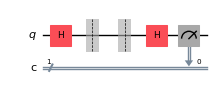

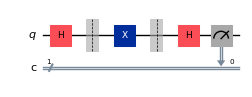

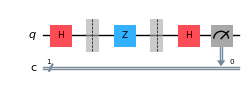

In [3]:
QasmSim = QasmSimulator() #Set simulator to evolve state

def apply_random_error(qc, qubit_idx, p_x, p_z):
    """Apply random X or Z error with given probabilities
    
    Args:
        qc (QuantumCircuit): Circuit to apply error to
        qubit_idx (int): Index of qubit to apply error
        p_x (float): Probability of X error
        p_z (float): Probability of Z error
    """
    r = np.random.random()
    if r < p_x:
        qc.x(qubit_idx)  # Bit flip
    elif r < p_x + p_z:
        qc.z(qubit_idx)  # Phase flip

def single_qubit_error_demo(p_error=0.2):
    """Demonstrate errors on a single qubit"""
    qc = create_error_circuit(p_error=p_error)

    job = QasmSim.run(qc, shots=1)
    result = job.result()
    count = result.get_counts()
    return count

def create_error_circuit(p_error=0.2):
    """Create quantum circuit with random error"""
    qc = QuantumCircuit(1, 1)
    qc.h(0)    # Prepare |+⟩ state
    qc.barrier()
    apply_random_error(qc, 0, p_x=p_error, p_z=p_error)
    qc.barrier()
    qc.h(0)
    qc.measure(0, 0)
    return qc

# Create and draw example circuit
circuits = []
for i in range(3):
    qc = create_error_circuit(p_error=0.2)
    display(qc.draw('mpl',scale=0.5))

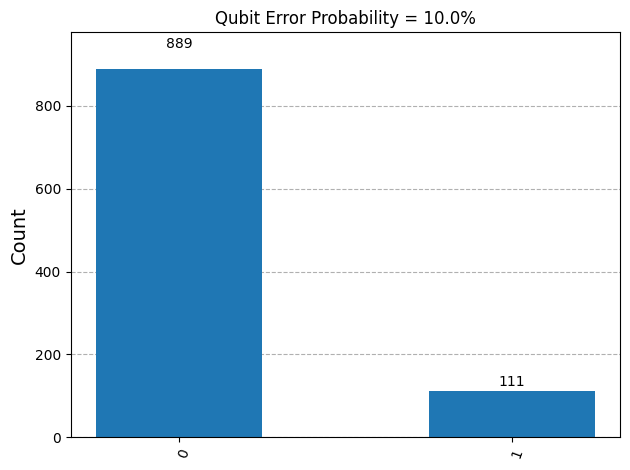

In [5]:
'''Run simulation many times with random errors each instance'''

nshots = 1000
shots = arange(nshots)

p_error = 0.1

counts = {}
for shot in shots: 
    counts = combine_counts(counts, single_qubit_error_demo(p_error=p_error))

plot_histogram(counts, title=('Qubit Error Probability = ' + str(p_error*100) + '%') , sort='asc')

## Run on IBM QPU

In [6]:
# Check if token needs to be set
token = "INSERT YOUR TOKEN HERE"

if token == "INSERT YOUR TOKEN HERE":
    token = input("Please enter your IBM Quantum token: ")

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True,
  set_as_default=True
)


### Simulate

In [8]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

service = QiskitRuntimeService()

backend = FakeBrisbane()
backend.refresh(service)

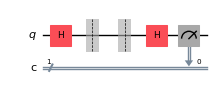

In [9]:
qc = create_error_circuit(p_error=0)
qc.draw('mpl',scale=0.5)

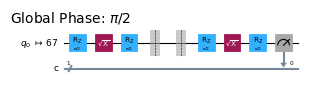

In [10]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

{'0': 972, '1': 28}
Error rate: 2.80%


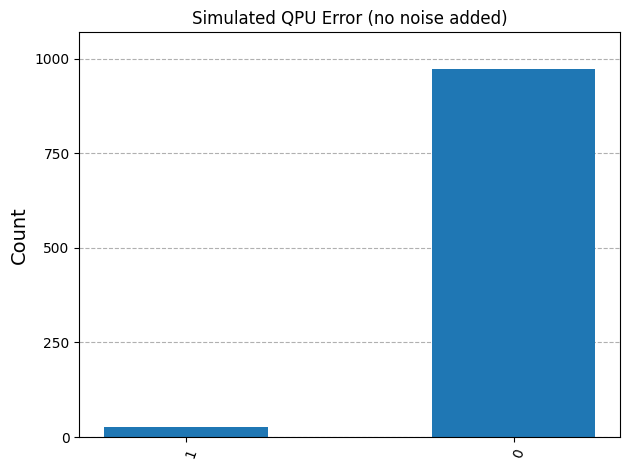

In [13]:
shots = 1000
job = backend.run(tqc, shots=shots)
result = job.result()

counts = result.get_counts()
print(counts)
print(f"Error rate: {100*counts['1']/shots:.2f}%")

plot_histogram(counts,title='Simulated QPU Error (no noise added)' , sort = 'value', bar_labels=False)

### Real QPU

In [14]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_kyiv')>


In [110]:
sampler = Sampler(backend)
job = sampler.run([tqc],shots=shots)

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=1>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-05 13:00:07', stop='2025-04-05 13:00:08', size=1000>)])}, 'version': 2})
Error rate: 1.20%


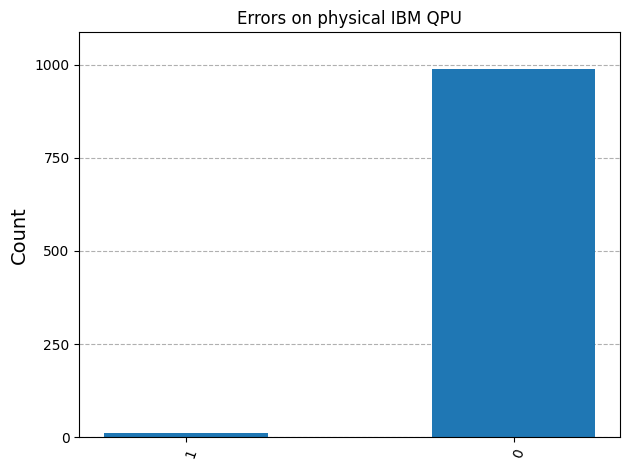

In [113]:
result = job.result()
print(result)
counts = result[0].data.c.get_counts()

print(f"Error rate: {100*counts['1']/shots:.2f}%")

plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

# Part 2: The 3-Qubit Bit Flip Code (repetition code)

The simplest quantum error correction code protects against bit flip errors by encoding:
- $|0⟩ → |000⟩$
- $|1⟩ → |111⟩$

This encoding allows us to detect and correct single bit flip errors through majority voting.

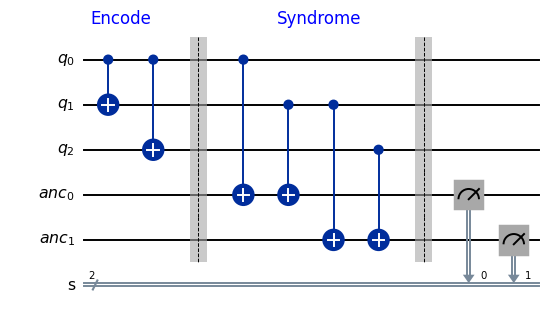

In [15]:
def create_3qubit_code():
    """Create a circuit implementing the 3-qubit bit flip code"""
    # Create registers
    qr = QuantumRegister(3, 'q')
    # cr = ClassicalRegister(3, 'c')
    anc = QuantumRegister(2, 'anc')  # Ancilla qubits for syndrome measurement
    syndrome = ClassicalRegister(2, 's')
    qc = QuantumCircuit(qr, anc, syndrome)
    
    # Encoding
    qc.cx(0, 1)  # Spread information to other qubits
    qc.cx(0, 2)
    
    # Add barrier to separate encoding
    qc.barrier()
    
    return qc

def add_syndrome_measurement(qc, with_barrier=True):
    """Add syndrome measurement circuit"""
    # Measure ZZ between first and second qubit
    qc.cx(0, 3)
    qc.cx(1, 3)
    # Measure ZZ between second and third qubit
    qc.cx(1, 4)
    qc.cx(2, 4)

    if with_barrier:
        qc.barrier()

    # Measure ancillas
    qc.measure([3,4], [0,1])
    return qc

qc = create_3qubit_code()
qc = add_syndrome_measurement(qc)

fig = qc.draw(output='mpl', scale = 0.7)

ax = fig.axes[0]
ax.text(0.15, 1.0, 'Encode', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.5, 1.0, 'Syndrome', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

## Syndrome Measurements

The syndrome measurements tell us which qubit (if any) experienced a bit flip:

| Syndrome | Error Location |
|----------|----------------|
| $0_{a1}$ $0_{a0}$       | No error      |
| $1_{a1}$ $0_{a0}$       | q2      |
| $1_{a1}$ $1_{a0}$       | q1      |
| $0_{a1}$ $1_{a0}$       | q0      |


Complete the following tasks:
1. Add random bit flip errors to the circuit
2. Interpret the syndrome measurements
3. Apply correction based on syndrome results

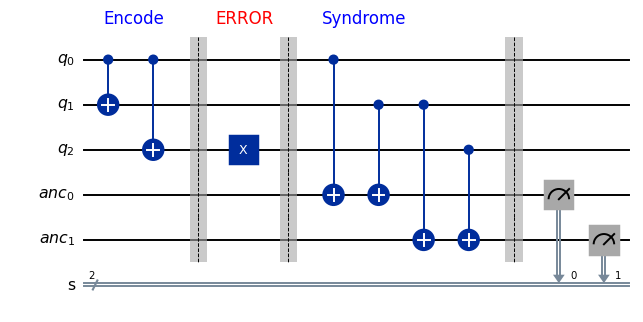

In [16]:
p_error = 0.3
# Create circuit

qc = create_3qubit_code()

error_added = False
# Add random bit flip errors
for i in range(3):
    if np.random.random() < p_error:
        qc.x(i)
        error_added = True
        break #only one error at a time!!!

qc.barrier()

# Add syndrome measurement
qc = add_syndrome_measurement(qc)

fig = qc.draw(output='mpl', scale = 0.7)

ax = fig.axes[0]
ax.text(0.15, 1.0, 'Encode', transform=ax.transAxes, fontsize=12, color='blue')
if error_added:
    ax.text(0.33, 1.0, 'ERROR', transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.5, 1.0, 'Syndrome', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

{'10': 100}


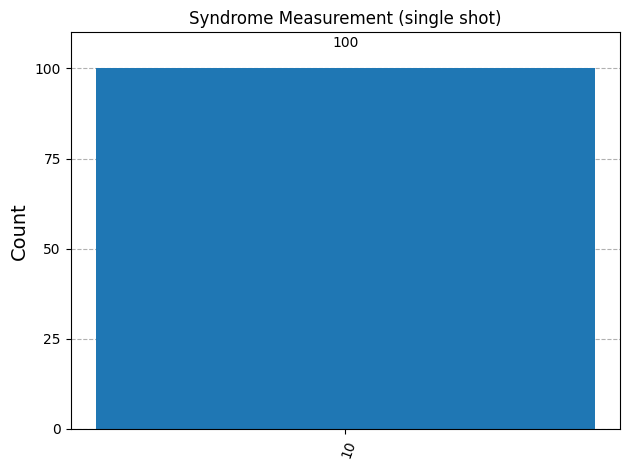

In [18]:
job = QasmSim.run(qc, shots=100)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts, title='Syndrome Measurement (single shot)' , sort='asc')

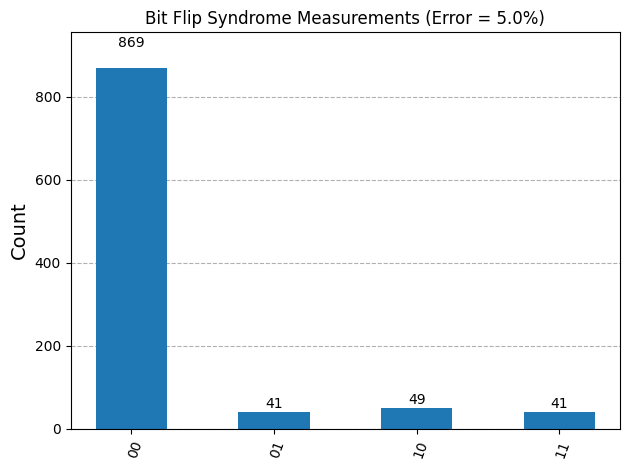

In [ ]:
def run_error_correction(initial_state=0, p_error=0.2):
    """Run full error correction protocol
    
    Args:
        initial_state (int): 0 or 1 for initial logical state
        p_error (float): Probability of bit flip on each qubit
        n_shots (int): Number of circuit executions
    """
    # Create circuit
    qc = create_3qubit_code()
    
    # Initialize if needed
    if initial_state == 1:
        qc.x(0)
    
    # Add random errors
    for i in range(3):
        if np.random.random() < p_error:
            qc.x(i)
    
    # Add syndrome measurement
    qc = add_syndrome_measurement(qc)
    
    # Execute
    job = QasmSim.run(qc, shots=1)

    result = job.result()
    counts = result.get_counts()
    
    return counts

# Run Simulation with errors and display Syndrome measurements
p_error=0.05
nshots = 1000
shots = arange(nshots)
counts = {}
for shot in shots: 
    counts = combine_counts(counts, run_error_correction(p_error=p_error))

plot_histogram(counts, title=('Bit Flip Syndrome Measurements (Error = ' + str(round(p_error*100,2)) + '%)') , sort='asc')

## Simulate on fake QPU

In [20]:
backend = FakeBrisbane()

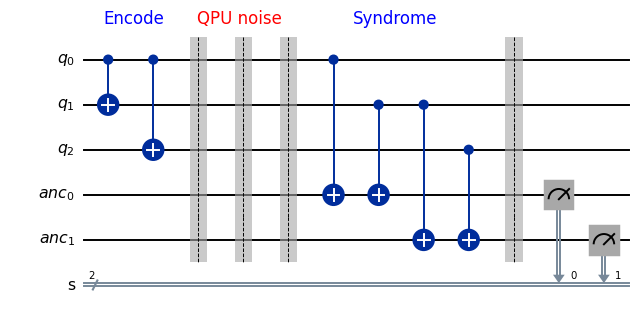

In [22]:
qc = create_3qubit_code()
qc.barrier()
qc.barrier()

qc = add_syndrome_measurement(qc,with_barrier=True)


fig = qc.draw(output='mpl', scale = 0.7)

ax = fig.axes[0]
ax.text(0.15, 1.0, 'Encode', transform=ax.transAxes, fontsize=12, color='blue')
if error_added:
    ax.text(0.3, 1.0, 'QPU noise', transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.55, 1.0, 'Syndrome', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

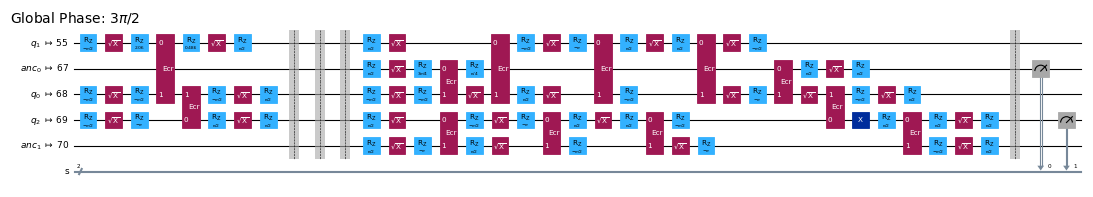

In [26]:
# tqc = transpile(qc, backend)
# tqc.draw('mpl',scale=0.4 ,fold = 50)

pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 50)

{'10': 215, '01': 222, '11': 120, '00': 443}
Error Analysis:
No error (00): 44.30%
Q0 error (10): 21.50%
Q1 error (11): 12.00%
Q2 error (01): 22.20%


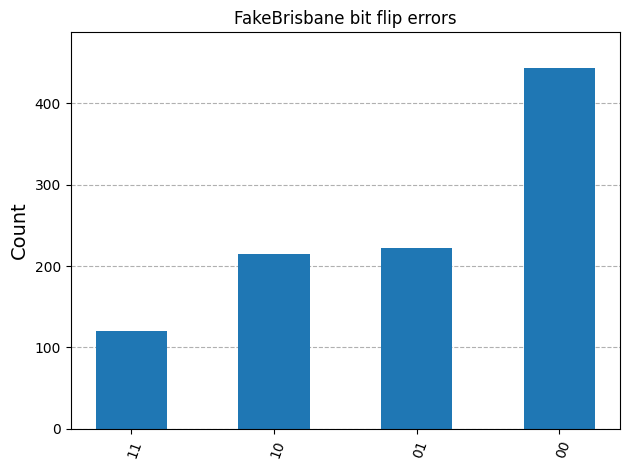

In [27]:
shots = 1000
job = backend.run(qc, shots=shots)
result = job.result()

counts = result.get_counts()
# print(counts)

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='FakeBrisbane bit flip errors' , sort = 'value', bar_labels=False)

## Real QPU

In [52]:
# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_sherbrooke')>


ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)


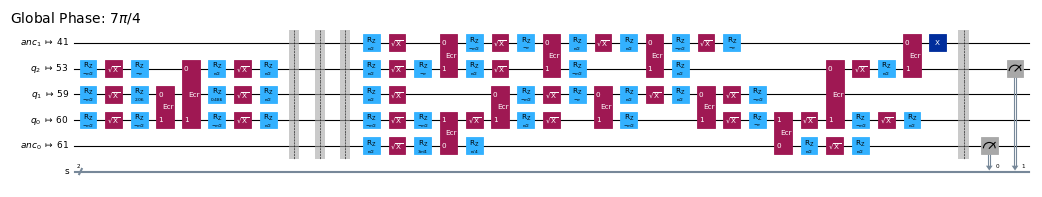

In [54]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

In [55]:
sampler = Sampler(backend) #define the backend QPU to run on
job = sampler.run([tqc],shots=shots) #run on the QPU

PrimitiveResult([SamplerPubResult(data=DataBin(s=BitArray(<shape=(), num_shots=1000, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-05 18:13:56', stop='2025-04-05 18:13:57', size=1000>)])}, 'version': 2})
{'11': 21, '00': 870, '01': 58, '10': 51}
Error Analysis:
No error (00): 87.00%
Q0 error (10): 5.10%
Q1 error (11): 2.10%
Q2 error (01): 5.80%


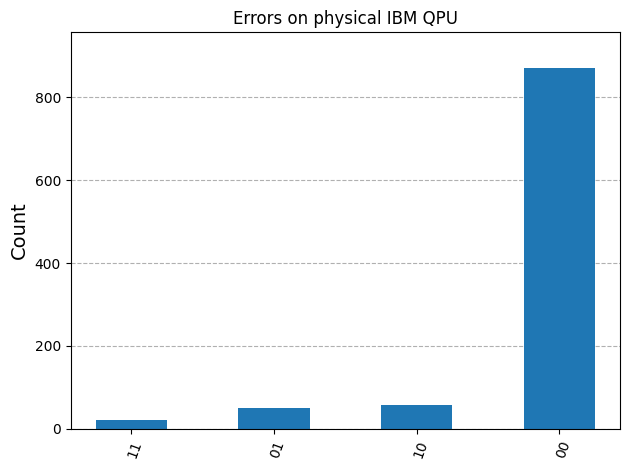

In [56]:
result = job.result()
print(result)
counts = result[0].data.s.get_counts() #in a 'string' s? now?

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

# The 3-Qubit Phase flip code
 
After looking at bit flip errors, we now turn our attention to phase flip errors.
Phase flip errors occur when a qubit's phase is inverted, changing the sign of the quantum state.
While bit flip errors flip between |0⟩ and |1⟩, phase flip errors flip between |+⟩ and |-⟩.

The 3-qubit phase flip code is similar to the bit flip code, but operates in the X-basis rather than Z-basis.
It uses Hadamard gates to transform between bases, encoding logical |+⟩ and |-⟩ states across 3 physical qubits.

Below we'll implement the encoding circuit for the 3-qubit phase flip code and examine how it protects against phase errors.

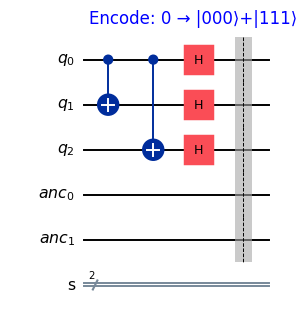

In [83]:
def create_3qubit_phase_code():
    """Create a circuit implementing the 3-qubit phase flip code"""
    qr = QuantumRegister(3, 'q')
    anc = QuantumRegister(2, 'anc')  # Ancilla qubits for syndrome measurement
    syndrome = ClassicalRegister(2, 's')
    qc = QuantumCircuit(qr, anc, syndrome)
    
    # Encoding
    qc.cx(0, 1)  # Spread information to other qubits
    qc.cx(0, 2)
    for qubit in range(0,3):
        qc.h(qubit)
    # Add barrier to separate encoding
    qc.barrier()
    return qc

qc = create_3qubit_phase_code()

fig = qc.draw(output='mpl', scale = 0.7)
ax = fig.axes[0]
ax.text(0.3, 1.0, 'Encode: 0 → |000⟩+|111⟩', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

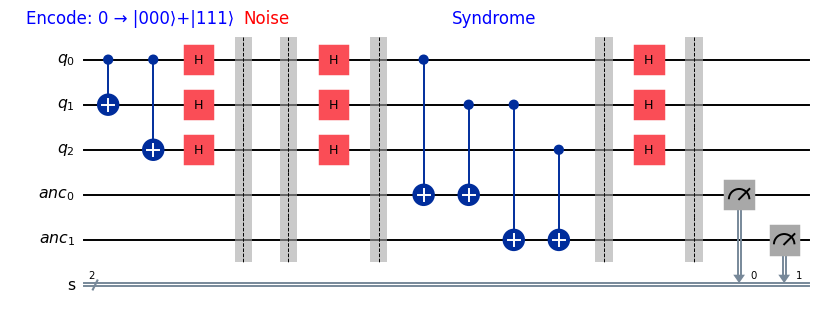

In [85]:
def add_phase_syndrome_measurement(qc, with_barriers=True):
    """Add Phase syndrome measurement circuit"""

    for qubit in range(0,3):
        qc.h(qubit)
    if with_barriers:
        qc.barrier()

    # Measure ZZ between first and second qubit
    qc.cx(0, 3)
    qc.cx(1, 3)
    # Measure ZZ between second and third qubit
    qc.cx(1, 4)
    qc.cx(2, 4)

    qc.barrier()
    for qubit in range(0,3):
        qc.h(qubit)
    qc.barrier()

    # Measure ancillas
    qc.measure([3,4], [0,1])
    return qc


def create_phase_code_with_error(p_error=0.3):
    """Create a 3-qubit phase code circuit with random phase flip error
    
    Args:
        p_error (float): Probability of phase flip error on each qubit
     
    Returns:
        QuantumCircuit: Circuit with encoding and random error
    """
    qc = create_3qubit_phase_code()

    # Add random phase flip errors
    for i in range(3):
        if np.random.random() < p_error:
            qc.z(i)
            break # only one error at a time!!

    qc.barrier()
    qc = add_phase_syndrome_measurement(qc)
    return qc

qc = create_phase_code_with_error()

fig = qc.draw(output='mpl', scale = 0.7)
ax = fig.axes[0]
ax.text(0.02, 1.0, 'Encode: 0 → |000⟩+|111⟩', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.29, 1.0, 'Noise', transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.55, 1.0, 'Syndrome', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

In [31]:
# job = QasmSim.run(qc, shots=1)
# result = job.result()
# counts = result.get_counts()
# plot_histogram(counts, title='Phase Syndrome Measurement (single shot)' , sort='asc')

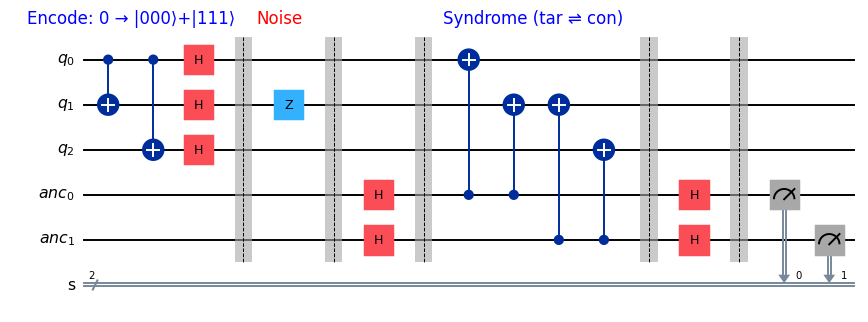

In [87]:
def add_phase_syndrome_measurement(qc, with_barriers=True):
    """Add Phase syndrome measurement circuit"""

    qc.h(3)
    qc.h(4)
    if with_barriers:
        qc.barrier()

    # Measure ZZ between first and second qubit
    qc.cx(3, 0) #reversed!
    qc.cx(3, 1) #reversed!

    # Measure ZZ between second and third qubit
    qc.cx(4, 1) #reversed!
    qc.cx(4, 2) #reversed!

    qc.barrier()
    qc.h(3)
    qc.h(4)
    qc.barrier()

    qc.measure([3,4], [0,1])# Measure ancillas
    return qc


def create_phase_code_with_error(p_error=0.3):
    """Create a 3-qubit phase code circuit with random phase flip error
    
    Args:
        p_error (float): Probability of phase flip error on each qubit
        
    Returns:
        QuantumCircuit: Circuit with encoding and random error
    """
    qc = create_3qubit_phase_code()

    # Add random phase flip errors
    for i in range(3):
        if np.random.random() < p_error:
            qc.z(i)
            break # only one error at a time!!

    qc.barrier()
    qc = add_phase_syndrome_measurement(qc)
    return qc

qc = create_phase_code_with_error()

fig = qc.draw(output='mpl', scale = 0.7)
ax = fig.axes[0]
ax.text(0.02, 1.0, 'Encode: 0 → |000⟩+|111⟩', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.29, 1.0, 'Noise', transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.51, 1.0, 'Syndrome (tar ⇌ con)', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

In [36]:
# job = QasmSim.run(qc, shots=1)
# result = job.result()
# counts = result.get_counts()
# plot_histogram(counts, title='Phase Syndrome Measurement (single shot)' , sort='asc')

{'00': 851, '11': 55, '01': 50, '10': 44}
{'00': 851, '11': 55, '10': 50, '01': 44}
Error Analysis:
No error (00): 85.10%
Q0 error (10): 5.00%
Q1 error (11): 5.50%
Q2 error (01): 4.40%


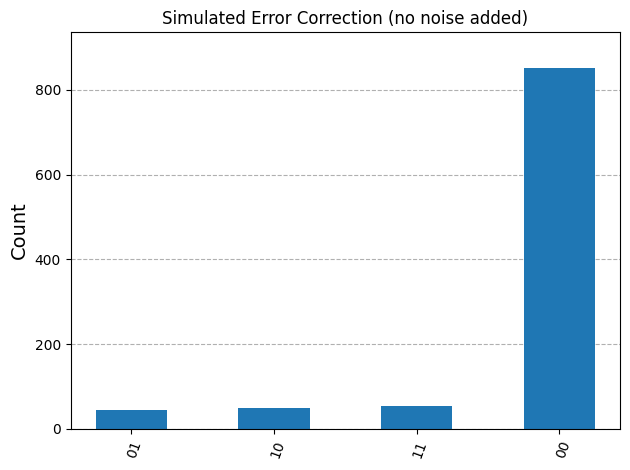

In [43]:
def run_error_correction(initial_state=0, p_error=0.2):
    """Run full error correction protocol
    
    Args:
        initial_state (int): 0 or 1 for initial logical state
        p_error (float): Probability of bit flip on each qubit
        n_shots (int): Number of circuit executions
    """
    if initial_state == 1:
        qc.x(0)    
        
    qc = create_3qubit_phase_code()

    for i in range(3):
        if np.random.random() < p_error:
            qc.z(i) #add phase noise
            break

    qc.barrier()
    qc = add_phase_syndrome_measurement(qc)
    
    job = QasmSim.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    
    return counts

'''Run Simulation with errors and display Syndrome measurements'''

p_error=0.05

nshots = 1000
shots = arange(nshots)

counts = {}
for shot in shots: 
    counts = combine_counts(counts, run_error_correction(p_error=p_error))

print(counts)
shots=1000

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='Simulated Error Correction (no noise added)' , sort = 'value', bar_labels=False)

## Simulate on QPU

In [39]:
backend = FakeBrisbane()

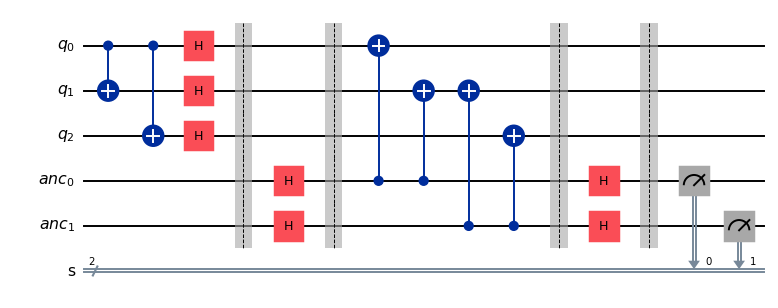

In [40]:
qc = create_3qubit_phase_code()
qc = add_phase_syndrome_measurement(qc,with_barriers=True)

qc.draw('mpl', scale=0.7)

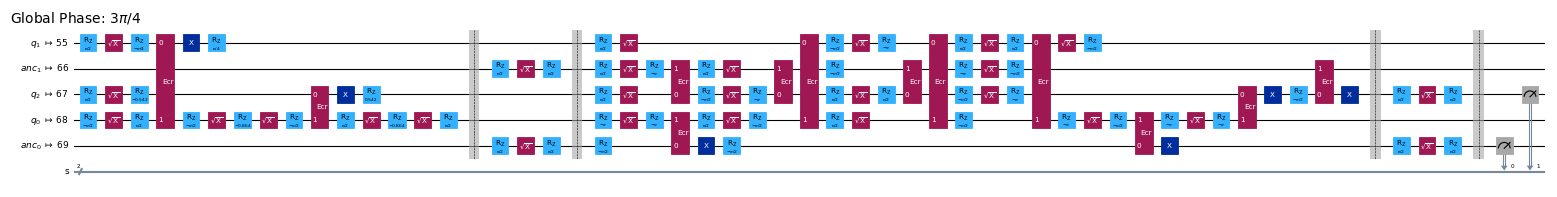

In [41]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

{'10': 169, '00': 735, '11': 40, '01': 56}
Error Analysis:
No error (00): 73.50%
Q0 error (10): 16.90%
Q1 error (11): 4.00%
Q2 error (01): 5.60%


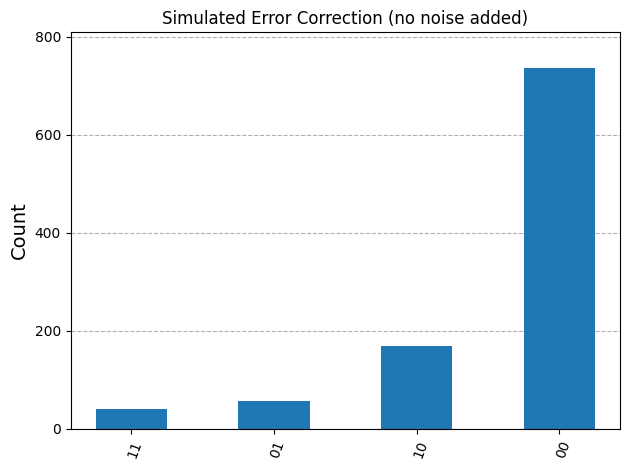

In [42]:
shots = 1000
job = backend.run(tqc, shots=shots)
result = job.result()

counts = result.get_counts()

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='Simulated Error Correction (no noise added)' , sort = 'value', bar_labels=False)

Excellent. Shots with no errors are most likely by far!

## Phase flips on real QPU

In [44]:
# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_kyiv')>


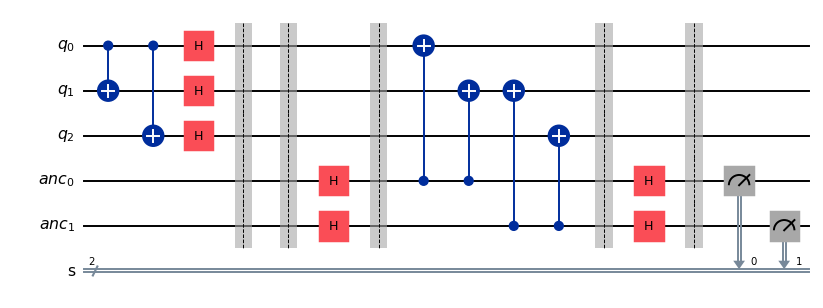

In [228]:
# qc = create_3qubit_phase_code()
# qc = add_phase_syndrome_measurement(qc,with_barriers=True)

qc = create_phase_code_with_error(p_error=0)
qc.draw('mpl', scale=0.7)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)


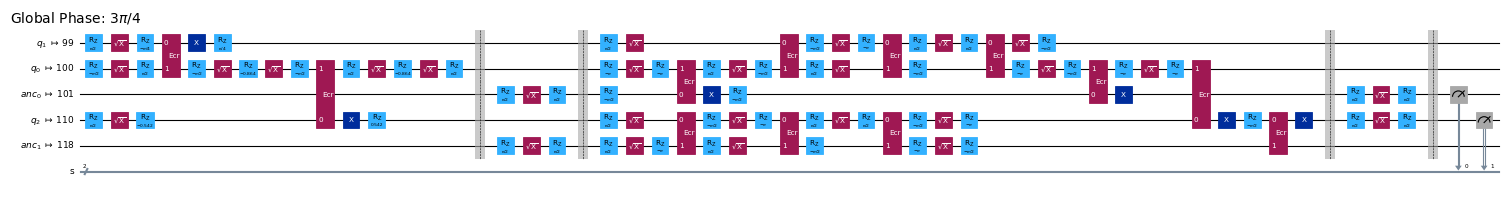

In [225]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

In [226]:
sampler = Sampler(backend) #define the backend QPU to run on
job = sampler.run([tqc],shots=shots) #run on the QPU
result = job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(s=BitArray(<shape=(), num_shots=1000, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-05 19:44:58', stop='2025-04-05 19:44:59', size=1000>)])}, 'version': 2})
{'11': 51, '00': 742, '10': 128, '01': 79}
Error Analysis:
No error (00): 74.20%
Q0 error (10): 12.80%
Q1 error (11): 5.10%
Q2 error (01): 7.90%


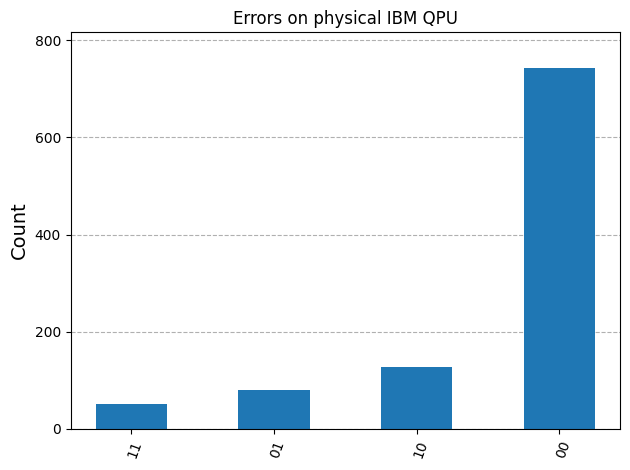

In [227]:
print(result)
counts = result[0].data.s.get_counts() #in a 'string' s? now?

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='Errors on physical IBM QPU' , sort = 'value', bar_labels=False)

Excellent the rate of phase errors is relatively low on a real QPU.

Now verify by adding a random error (and use a noisy QPU)

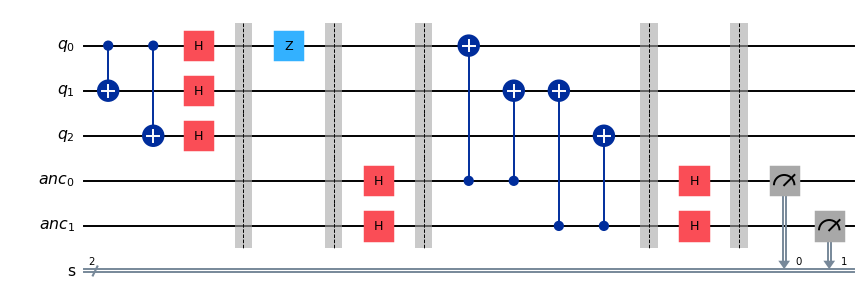

In [230]:

qc = create_phase_code_with_error(p_error=0.3)
qc.draw('mpl', scale=0.7)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)


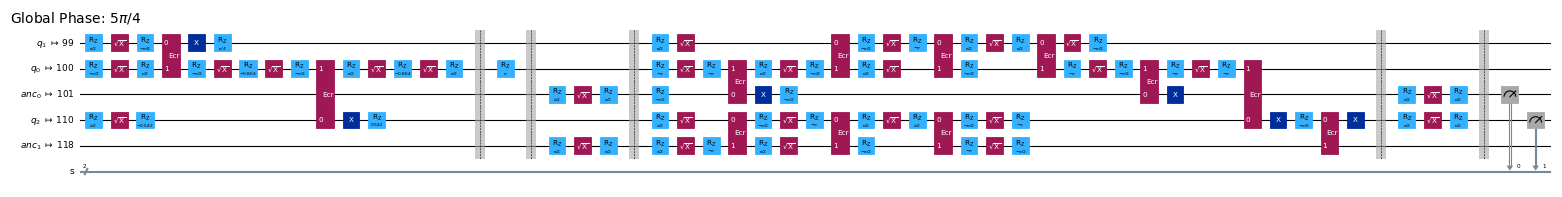

In [231]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

In [232]:
sampler = Sampler(backend) #define the backend QPU to run on
job = sampler.run([tqc],shots=shots) #run on the QPU
result = job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(s=BitArray(<shape=(), num_shots=1000, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-05 19:47:48', stop='2025-04-05 19:47:49', size=1000>)])}, 'version': 2})
{'11': 77, '00': 159, '10': 716, '01': 48}
Error Analysis:
No error (00): 15.90%
Q0 error (10): 71.60%
Q1 error (11): 7.70%
Q2 error (01): 4.80%


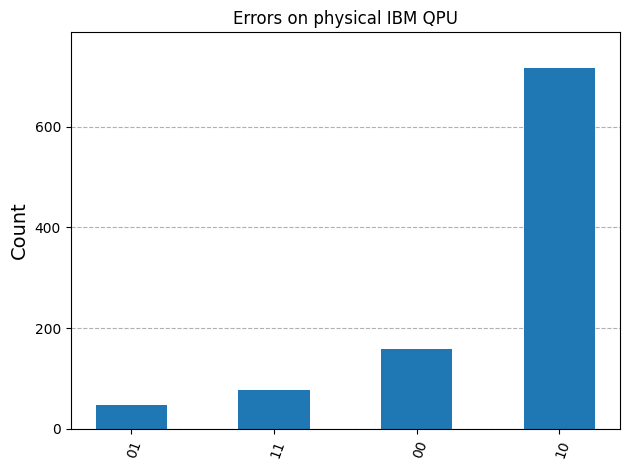

In [233]:
print(result)
counts = result[0].data.s.get_counts() #in a 'string' s? now?

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='Errors on physical IBM QPU' , sort = 'value', bar_labels=False)

Perfect! We verified that we can INSERT an error into our code and extract it with a syndrome measurement on a noisy QPU!!

# Part 3: The Shor 9-Qubit Code

The Shor code protects against both bit and phase flips by concatenating the 3-qubit bit flip code with the 3-qubit phase flip code.

The encoding transforms states as follows:

 $|0⟩_L → \frac{|000⟩ + |111⟩}{\sqrt{2}} \frac{|000⟩ + |111⟩}{\sqrt{2}} \frac{|000⟩ + |111⟩}{\sqrt{2}}$

$|1⟩_L → \frac{|000⟩ - |111⟩}{\sqrt{2}} \frac{|000⟩ - |111⟩}{\sqrt{2}} \frac{|000⟩ - |111⟩}{\sqrt{2}}$

Implementing the Shor Code

1. Create the encoding circuit for the Shor code
2. Add syndrome measurements for both X and Z errors
3. Test the code's ability to correct different types of errors

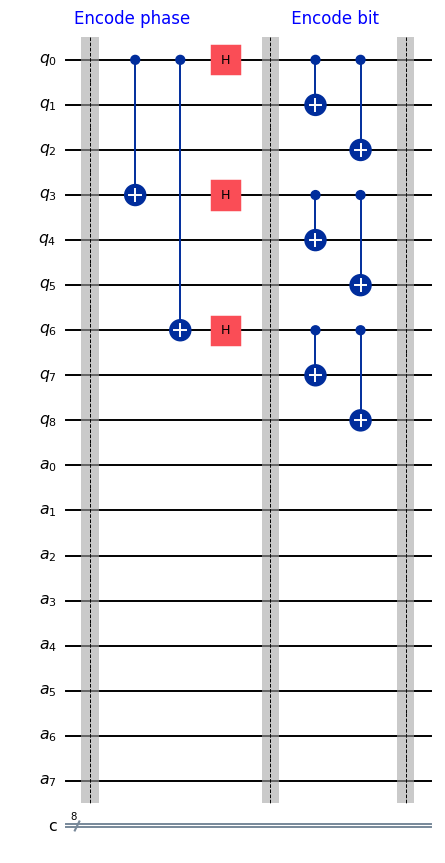

In [57]:
def encode_shor_code():
    """Create the 9-qubit Shor code circuit"""
    # Main registers
    qr = QuantumRegister(9, 'q')  # 9 data qubits
    anc = QuantumRegister(8, 'a')  # 8 ancilla qubits for syndrome measurements
    cr = ClassicalRegister(8, 'c')  # 8 classical bits for syndrome results
    qc = QuantumCircuit(qr, anc, cr)
    
    #Initialize input state
    # qc.h(0)

    qc.barrier()

    # First level encoding (phase flip code)
    qc.cx(0, 3)
    qc.cx(0, 6)
    
    # Second level encoding (bit flip code)
    qc.h(0)  
    qc.h(3)
    qc.h(6)    
    
    qc.barrier()

    for i in [0, 3, 6]:
        qc.cx(i, i+1)
        qc.cx(i, i+2)
        
    qc.barrier() # Separate encoding from errors/measurement

    return qc

# Create and display circuit
qc = encode_shor_code()
# qc.draw('mpl', scale=0.5)

fig = qc.draw(output='mpl', scale = 0.7)

ax = fig.axes[0]
ax.text(0.15, 1.0, 'Encode phase', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.65, 1.0, ' Encode bit', transform=ax.transAxes, fontsize=12, color='blue')
# ax.text(0.29, 1.0, 'Noise', transform=ax.transAxes, fontsize=12, color='red')
# ax.text(0.51, 1.0, 'Syndrome (tar ⇌ con)', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

In [58]:
def apply_random_errors_shor(qc, p_bit=0.1, p_phase=0.1):
    """Apply random bit and phase flip errors to the Shor code circuit
    
    Args:
        qc (QuantumCircuit): Circuit to apply errors to
        p_bit (float): Probability of bit flip on each qubit
        p_phase (float): Probability of phase flip on each qubit
    """
    for i in range(9):  # For each data qubit
        if np.random.random() < p_bit:
            qc.x(i)  # Bit flip
        if np.random.random() < p_phase:
            qc.z(i)  # Phase flip
    return qc


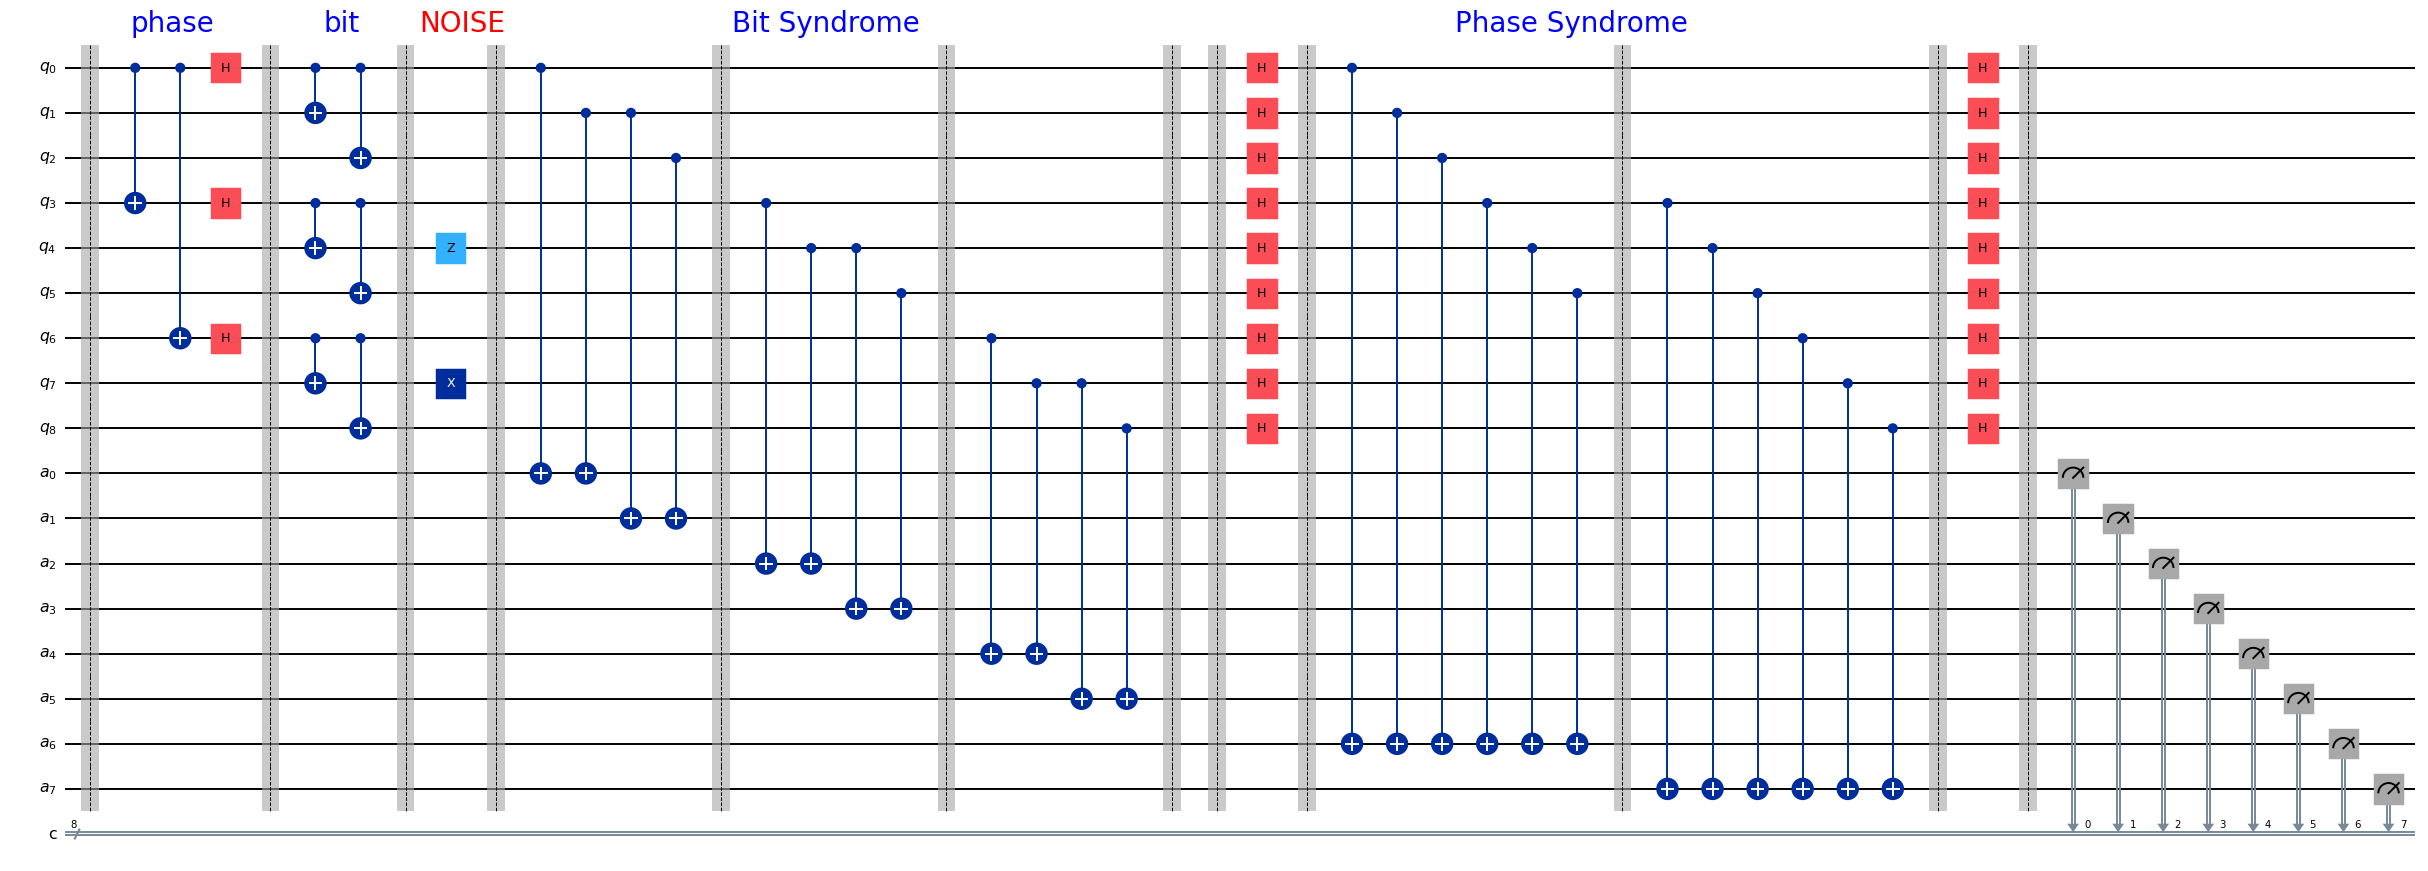

In [78]:
def shor_add_bit_syndrome_measurement(qc, anc, with_barriers=True):
    """Add Bit Flip syndrome measurement to Shor code"""

    # Bit flip Syndrome measurements
    for block in [0, 3, 6]:  # For each block of 3 qubits
        # ZZ measurement between first and second qubit
        qc.cx(block, anc[block//3*2])
        qc.cx(block+1, anc[block//3*2])

        # ZZ measurement between second and third qubit
        qc.cx(block+1, anc[block//3*2+1])
        qc.cx(block+2, anc[block//3*2+1])

        if with_barriers:
            qc.barrier()
        
    if with_barriers:
        qc.barrier()

    return qc

def shor_add_phase_syndrome_measurement(qc, anc, with_barriers=True):
    """Add Phase syndrome measurement to Shor code"""

    # Phase flip syndromes (between blocks)
    # (Convert Z errors to X errors)
    for qubit in range(0,9):
        qc.h(qubit)

    if with_barriers:
        qc.barrier()

    # Compare first and second block
    qc.cx(0, anc[6])
    qc.cx(1, anc[6])
    qc.cx(2, anc[6])

    qc.cx(3, anc[6])
    qc.cx(4, anc[6])
    qc.cx(5, anc[6])
    
    if with_barriers:
        qc.barrier()

    # Compare second and third block
    qc.cx(3, anc[7])  
    qc.cx(4, anc[7])  
    qc.cx(5, anc[7])  

    qc.cx(6, anc[7])
    qc.cx(7, anc[7])
    qc.cx(8, anc[7])
    
    if with_barriers:
        qc.barrier()

    for qubit in range(0,9):
        qc.h(qubit)

    if with_barriers:
        qc.barrier()

    return qc


def create_shor_code_with_syndromes(p_bit=0.1, p_phase=0.1, with_barriers=True, add_error=True, bit_syn=True, phase_syn = True, encode=True):
    """Create the 9-qubit Shor code circuit with syndrome measurements"""
    # Main registers
    qr = QuantumRegister(9, 'q')  # 9 data qubits
    anc = QuantumRegister(8, 'a')  # 8 ancilla qubits for syndrome measurements
    cr = ClassicalRegister(8, 'c')  # 8 classical bits for syndrome results
    qc = QuantumCircuit(qr, anc, cr)
    
    if encode:
        qc = encode_shor_code()

    '''
    Add random errors
    '''
    if add_error:
        qc = apply_random_errors_shor(qc, p_bit=p_bit, p_phase=p_phase)
    if with_barriers:
        qc.barrier()
    
    if bit_syn:
        '''Add Bit Flip Syndromes'''
        qc = shor_add_bit_syndrome_measurement(qc, anc, with_barriers)

    if phase_syn:
        '''Add Phase Flip Syndromes'''
        qc = shor_add_phase_syndrome_measurement(qc, anc, with_barriers)

    '''Measure all ancilla to get syndromes'''
    qc.measure(anc, cr)
    
    return qc

qc = create_shor_code_with_syndromes(p_bit=0.10, p_phase=0.10)
# qc.draw('mpl',scale=0.4 ,fold = 100)

fig = qc.draw(output='mpl', scale = 0.7,fold = 100)

ax = fig.axes[0]
fs=20
ax.text(0.05, 1.0, 'phase', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.13, 1.0, 'bit', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.17, 1.0, 'NOISE', transform=ax.transAxes, fontsize=fs, color='red')
ax.text(0.3, 1.0, 'Bit Syndrome', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.6, 1.0, 'Phase Syndrome', transform=ax.transAxes, fontsize=fs, color='blue')
display(fig)


## Syndrome Truth Table for the Shor Code

The syndrome measurements use 8 ancilla qubits total:
- 6 ancillas for bit flip detection  $\rightarrow 0_{a0}0_{a1}~0_{a2}0_{a3}~0_{a4}0_{a5}$

- 2 ancillas for phase flip detection  $\rightarrow 0_{a6}0_{a7}$


## 6 ancillas for bit flip detection

| Error | Bit flip Syndrome | Description |
|-------|----------|-------------|
| I  | 00 00 00 | No error |
| X1 | 10 00 00 | Bit-flip in qubit 1 |
| X2 | 11 00 00 | Bit-flip in qubit 2 |
| X3 | 01 00 00 | Bit-flip in qubit 3 |
| X4 | 00 10 00 | Bit-flip in qubit 4 |
| X5 | 00 11 00 | Bit-flip in qubit 5 |
| X6 | 00 01 00 | Bit-flip in qubit 6 |
| X7 | 00 00 10 | Bit-flip in qubit 7 |
| X8 | 00 00 11 | Bit-flip in qubit 8 |
| X9 | 00 00 01 | Bit-flip in qubit 9 |

## 2 ancillas for phase flip detection

| Error | Phase flip Syndrome | Description |
|-------|----------|-------------|
| Z123 | 10 | Phase-flip in qubit 1,2,3 |
| Z456 | 11 | Phase-flip in qubit 4,5,6 |
| Z789 | 01 | Phase-flip in qubit 7,8,9 |


## All together the full syndrome of the 8 ancillas is:


| Error | Full Syndrome | Description |
|-------|----------|-------------|
| I  | 00 00 00 00 | No error |
| X0 | 10 00 00 00 | Bit-flip in qubit 0 |
| X1 | 11 00 00 00 | Bit-flip in qubit 1 |
| X2 | 01 00 00 00 | Bit-flip in qubit 2 |
| X3 | 00 10 00 00 | Bit-flip in qubit 3 |
| X4 | 00 11 00 00 | Bit-flip in qubit 4 |
| X5 | 00 01 00 00 | Bit-flip in qubit 5 |
| X6 | 00 00 10 00 | Bit-flip in qubit 6 |
| X7 | 00 00 11 00 | Bit-flip in qubit 7 |
| X8 | 00 00 01 00 | Bit-flip in qubit 8 |
| Z012 | 00 00 00 10 | Phase-flip in qubit 0,1,2 |
| Z345 | 00 00 00 11 | Phase-flip in qubit 3,4,5 |
| Z678 | 00 00 00 01 | Phase-flip in qubit 6,7,8 |


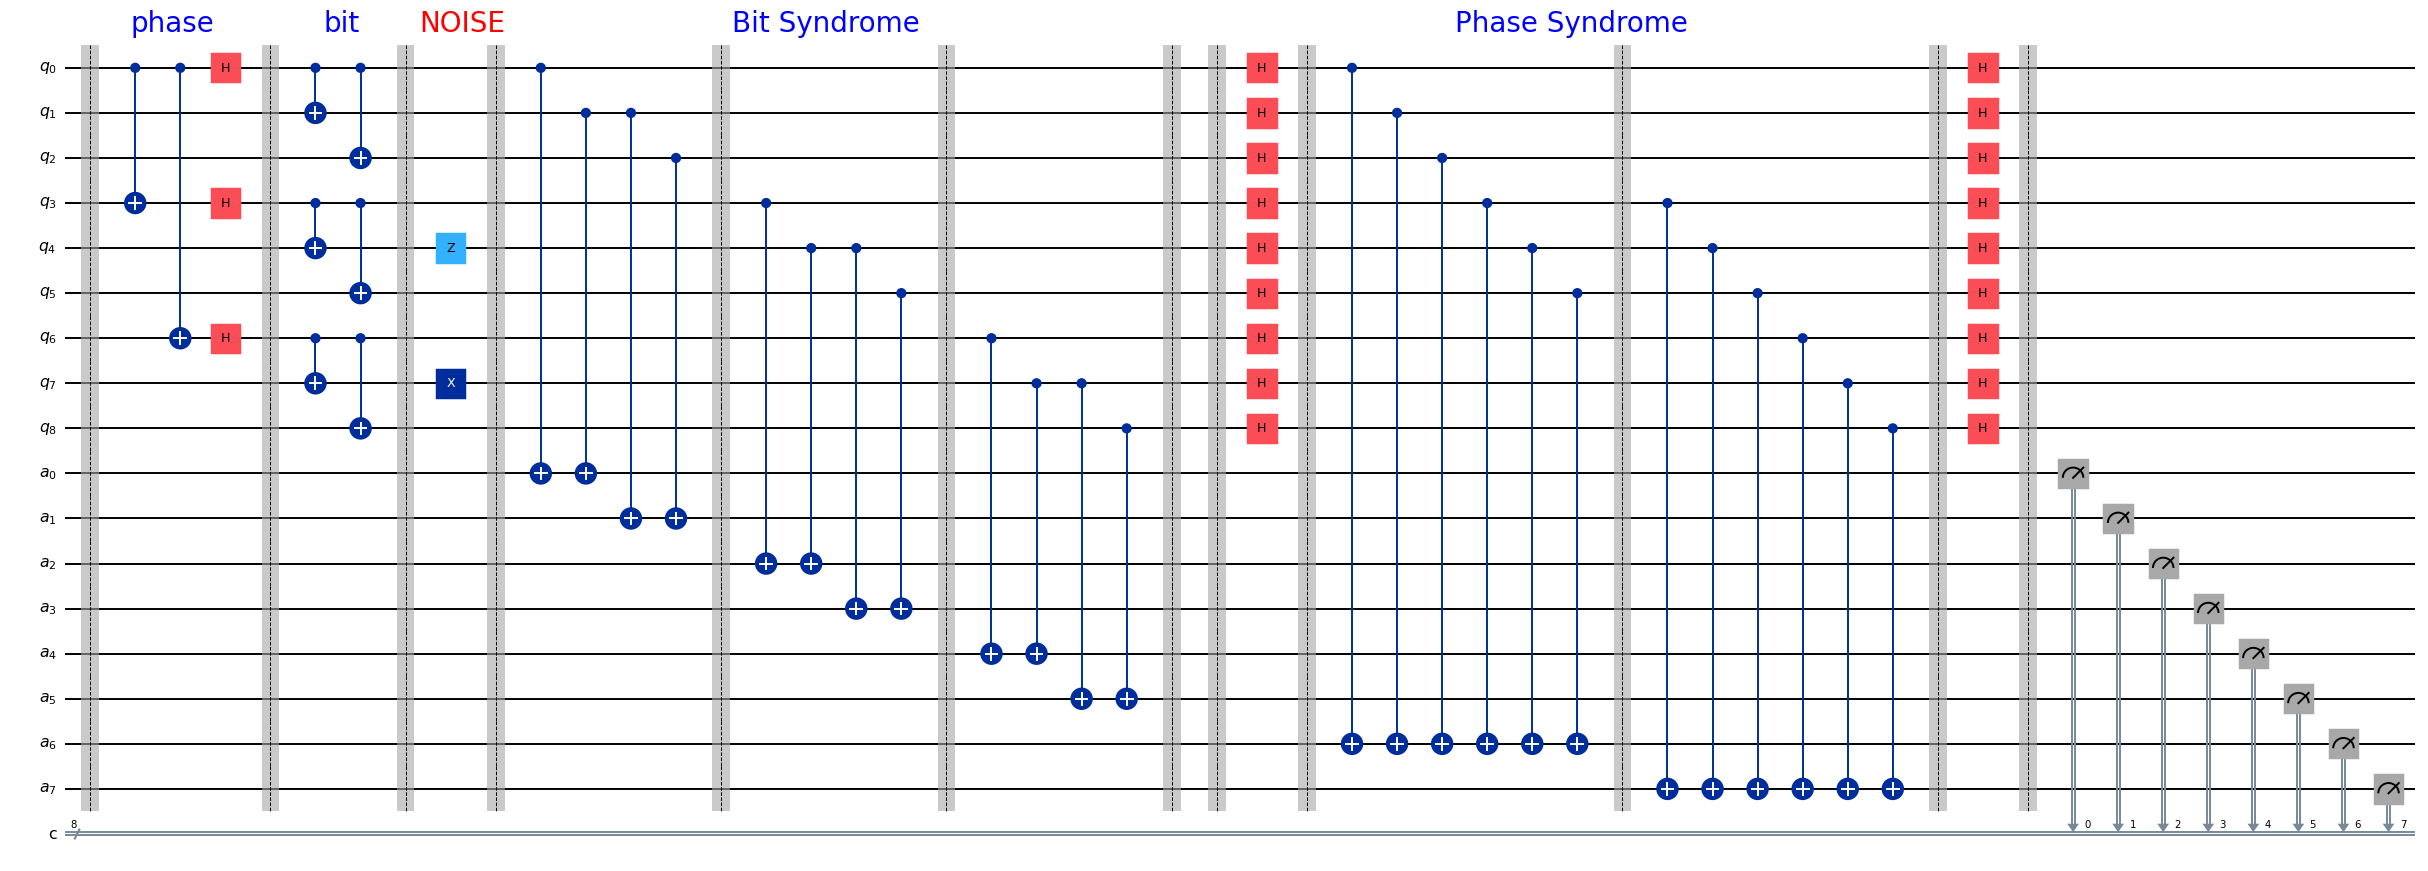

In [79]:
fig = qc.draw(output='mpl', scale = 0.7,fold = 100)
ax = fig.axes[0]
fs=20
ax.text(0.05, 1.0, 'phase', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.13, 1.0, 'bit', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.17, 1.0, 'NOISE', transform=ax.transAxes, fontsize=fs, color='red')
ax.text(0.3, 1.0, 'Bit Syndrome', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.6, 1.0, 'Phase Syndrome', transform=ax.transAxes, fontsize=fs, color='blue')
display(fig)

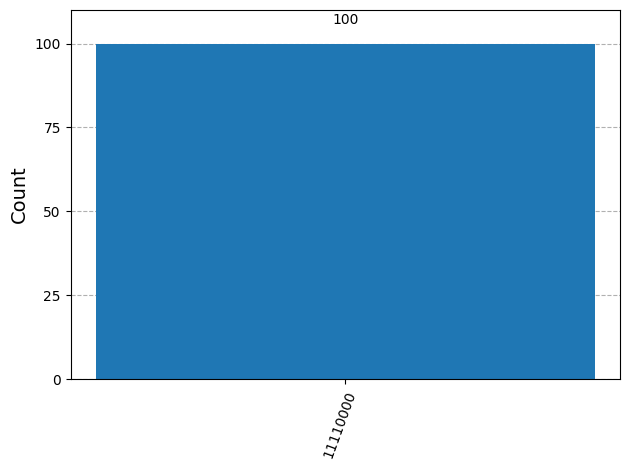

In [80]:
job = QasmSim.run(qc, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [81]:
# Get the measured syndrome from counts
syndrome = list(counts.keys())[0]  # Get the first (only) key
print(f"Measured full syndrome (Qiskit order): {syndrome}")
# Reverse the bit order
reversed_syndrome = syndrome[::-1]
print(f"Reversed full syndrome: {reversed_syndrome}")
# Split syndrome into bit and phase parts
bit_syndrome = reversed_syndrome[:6]  # First 6 bits for X errors
phase_syndrome = reversed_syndrome[-2:] # Last 2 bits for Z errors
print(f"Bit syndrome (first 6 bits): {bit_syndrome}")
print(f"Phase syndrome (last 2 bits): {phase_syndrome}")

# Create syndrome lookup tables
bit_error_lookup = {
    '000000': 'No bit-flip error',
    '100000': 'Bit-flip on qubit 0',
    '110000': 'Bit-flip on qubit 1', 
    '010000': 'Bit-flip on qubit 2',
    '001000': 'Bit-flip on qubit 3',
    '001100': 'Bit-flip on qubit 4',
    '000100': 'Bit-flip on qubit 5',
    '000010': 'Bit-flip on qubit 6',
    '000011': 'Bit-flip on qubit 7',
    '000001': 'Bit-flip on qubit 8'
}

phase_error_lookup = {
    '00': 'No phase-flip error',
    '10': 'Phase-flip on qubits 0,1,2',
    '11': 'Phase-flip on qubits 3,4,5', 
    '01': 'Phase-flip on qubits 6,7,8'
}

print('\n Results: \n')
# Look up and print the errors
print("Bit error:", bit_error_lookup.get(bit_syndrome, "Unknown bit error pattern"))
print("Phase error:", phase_error_lookup.get(phase_syndrome, "Unknown phase error pattern"))


Measured full syndrome (Qiskit order): 11110000
Reversed full syndrome: 00001111
Bit syndrome (first 6 bits): 000011
Phase syndrome (last 2 bits): 11

 Results: 

Bit error: Bit-flip on qubit 7
Phase error: Phase-flip on qubits 3,4,5


This verifies that the decoder is working properly and performing the proper bit string reversal!

## Ideal simulation (with bit and phase flips added)

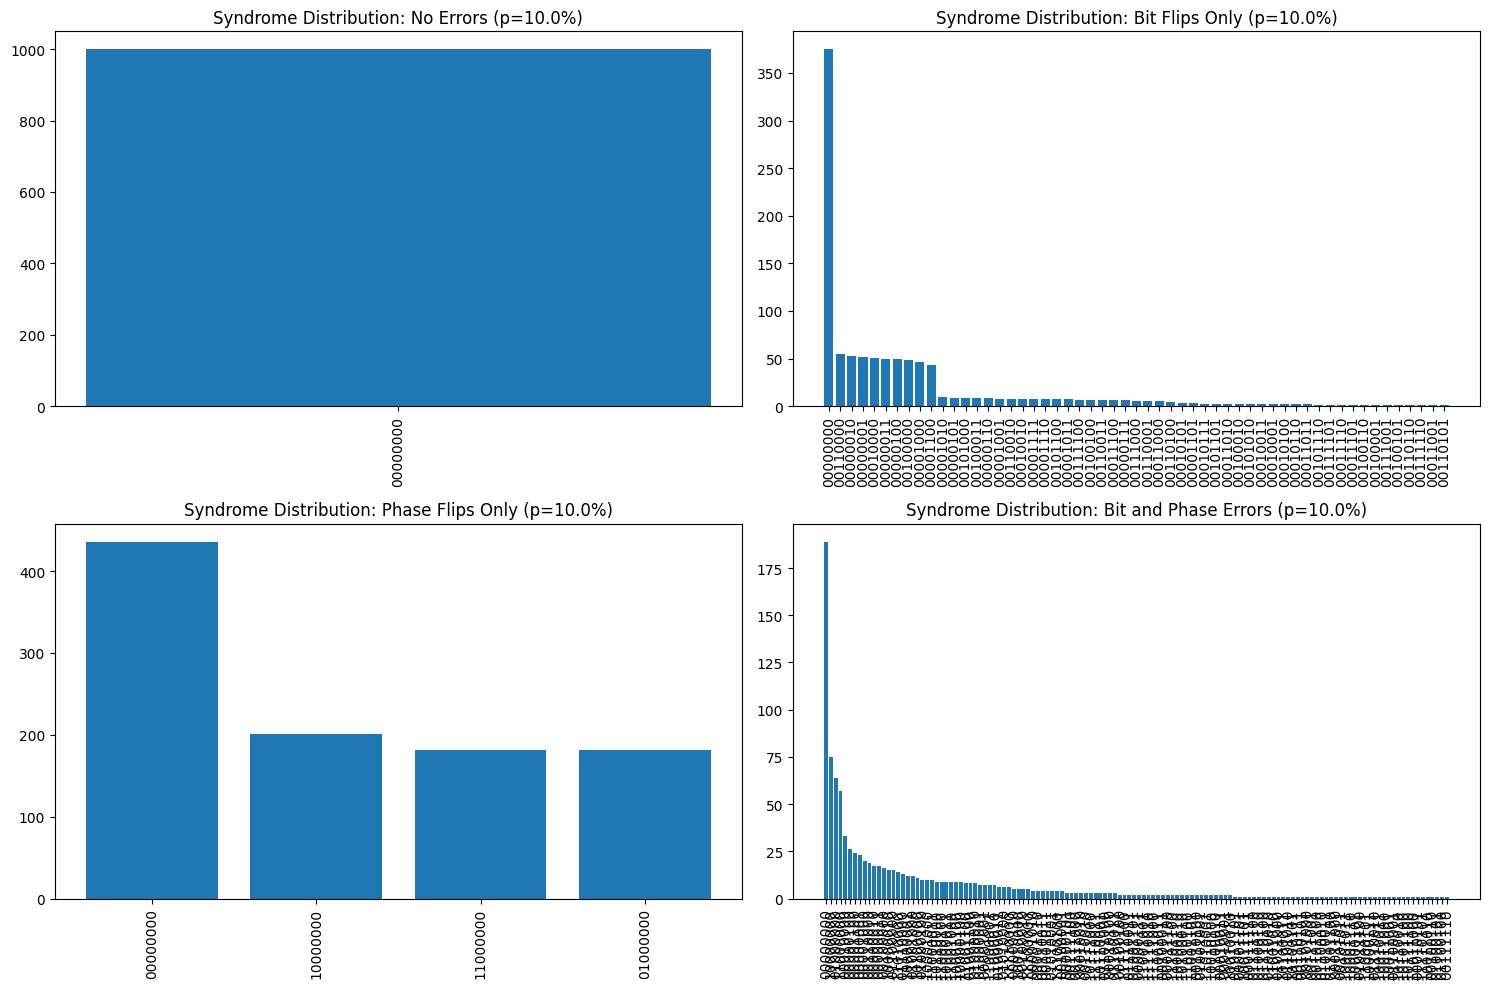

In [165]:
def run_shor_code_demo(initial_state=0, p_bit=0.1, p_phase=0.1, n_shots=1000):
    """Run full Shor code demonstration
    
    Args:
        initial_state (int): 0 or 1 for initial logical state
        p_bit (float): Bit flip error probability
        p_phase (float): Phase flip error probability
        n_shots (int): Number of circuit executions
    """
    # Create circuit
    qc = create_shor_code_with_syndromes(p_bit=p_bit, p_phase=p_phase)
        
    job = QasmSim.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    
    return counts

p_error = 0.1

# Run demonstration with different error scenarios
scenarios = [
    (0.0, 0.0, "No Errors"),
    (p_error, 0.0, "Bit Flips Only"),
    (0.0, p_error, "Phase Flips Only"),
    (p_error, p_error, "Bit and Phase Errors")
]

# Plot results for each scenario
plt.figure(figsize=(15, 10))
for i, (p_bit, p_phase, title) in enumerate(scenarios, 1):
    plt.subplot(2, 2, i)
    # counts = run_shor_code_demo(p_bit=p_bit, p_phase=p_phase)
    # plot_histogram(counts)

    counts = {}
    shots = arange(1000)
    for shot in shots: 
        counts = combine_counts(counts, run_shor_code_demo(p_bit=p_bit, p_phase=p_phase))
    # plot_histogram(counts)
    plt.bar(sorted(counts.keys(), key=lambda x: counts[x], reverse=True), [counts[k] for k in sorted(counts.keys(), key=lambda x: counts[x], reverse=True)])
    plt.xticks(rotation=90)

    plt.title(f"Syndrome Distribution: {title} (p={p_error*100}%)")

plt.tight_layout()
plt.show()


## Simulate Shor QEC on fake QPU

### First test the 'null' circuit... without any gates... just readout.

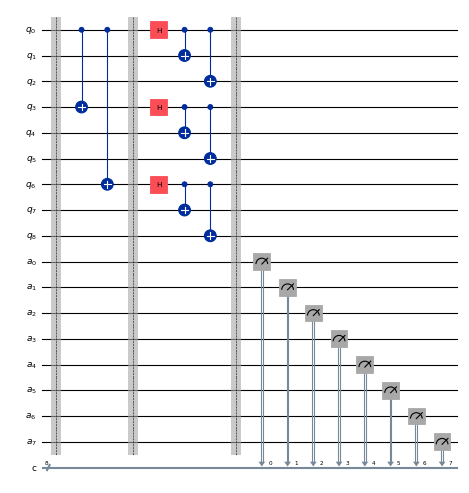

In [170]:
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=False, add_error=False, phase_syn=False, bit_syn=False, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

In [171]:
backend = FakeBrisbane()

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)


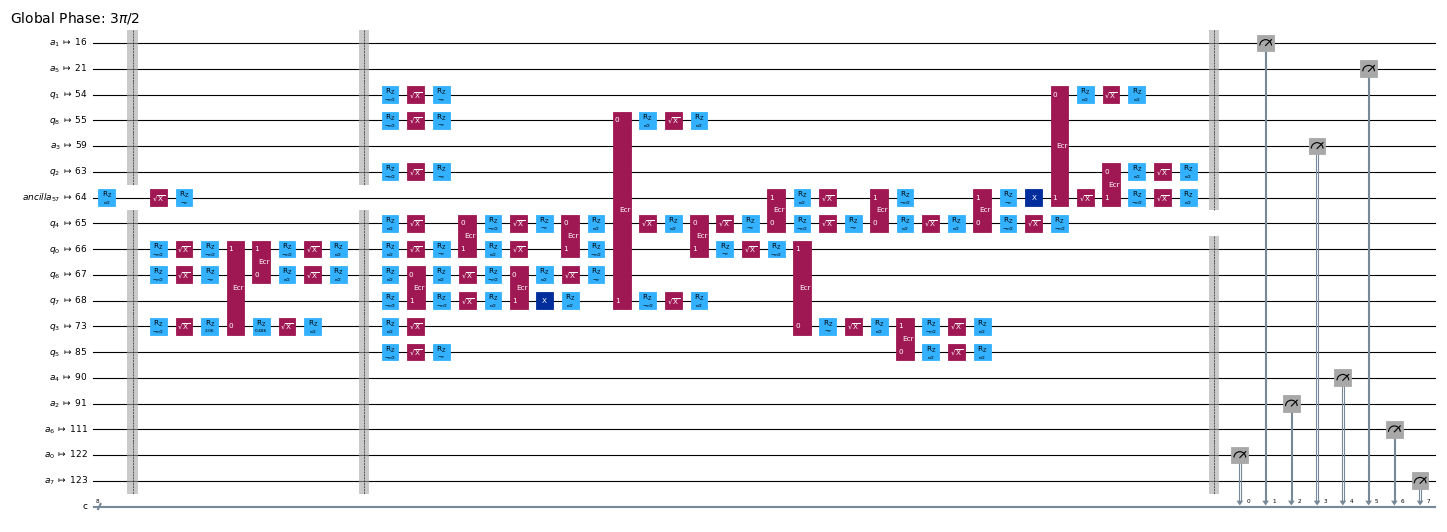

In [172]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

{'00000110': 18, '01000000': 32, '00001001': 11, '10100000': 11, '10000010': 13, '01000110': 5, '00000000': 162, '01000010': 9, '00110011': 2, '00000100': 55, '10000000': 35, '01000100': 8, '00000010': 56, '00100010': 21, '11010100': 1, '00010000': 35, '10100001': 1, '00001000': 55, '00101001': 5, '01011000': 2, '00010100': 11, '01101010': 2, '00110110': 2, '00101010': 6, '10101000': 3, '00000001': 29, '10010001': 3, '00100000': 30, '00000111': 7, '01000001': 11, '00110000': 5, '00011101': 2, '01100001': 2, '10001101': 2, '00000011': 16, '00110100': 1, '00101100': 3, '00100001': 11, '00001010': 18, '10010010': 2, '00100011': 6, '00001100': 12, '00001101': 5, '10010101': 2, '00100100': 7, '00100101': 5, '00001110': 7, '01001010': 3, '11000000': 7, '10001100': 2, '11010000': 1, '00111010': 3, '00100110': 4, '00011001': 2, '10001000': 7, '01101000': 3, '00101110': 2, '00110010': 4, '00010101': 3, '01010000': 8, '00101000': 15, '11001000': 2, '10001010': 7, '01100000': 7, '01001000': 10, '

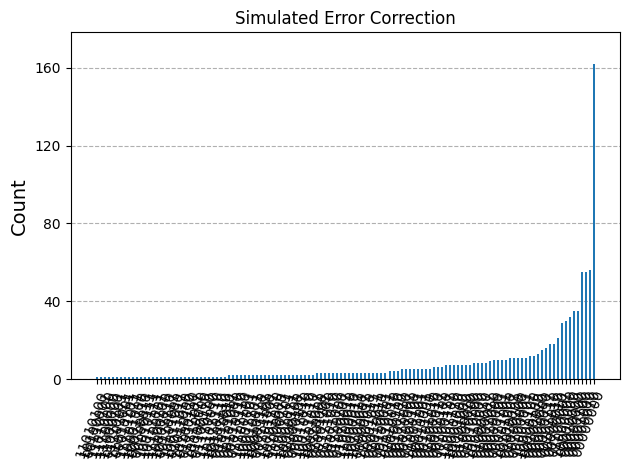

In [173]:
job = backend.run(tqc, shots=1000)
result = job.result()

counts = result.get_counts()
print(counts)
# Find the most frequent outcome
most_likely = max(counts.items(), key=lambda x: x[1])
print(f"\nMost likely outcome: {most_likely[0]} occurred {most_likely[1]} times ({(most_likely[1]/1000)*100:.1f}% of shots)")

plot_histogram(counts,title='Simulated Error Correction' , sort = 'value', bar_labels=False)


Bit-flip Error Analysis:
No bit-flip error: 263 (26.3%)
Bit-flip on qubit 0: 59 (5.9%)
Bit-flip on qubit 1: 10 (1.0%)
Bit-flip on qubit 2: 55 (5.5%)
Bit-flip on qubit 3: 68 (6.8%)
Bit-flip on qubit 4: 11 (1.1%)
Bit-flip on qubit 5: 56 (5.6%)
Bit-flip on qubit 6: 87 (8.7%)
Bit-flip on qubit 7: 24 (2.4%)
Bit-flip on qubit 8: 90 (9.0%)
Other bit-flip errors: 277 (27.7%)

Phase-flip Error Analysis:
No phase-flip error: 576 (57.6%)
Phase-flip on qubits 0–2: 226 (22.6%)
Phase-flip on qubits 3–5: 56 (5.6%)
Phase-flip on qubits 6–8: 142 (14.2%)
Other phase-flip errors: 0 (0.0%)


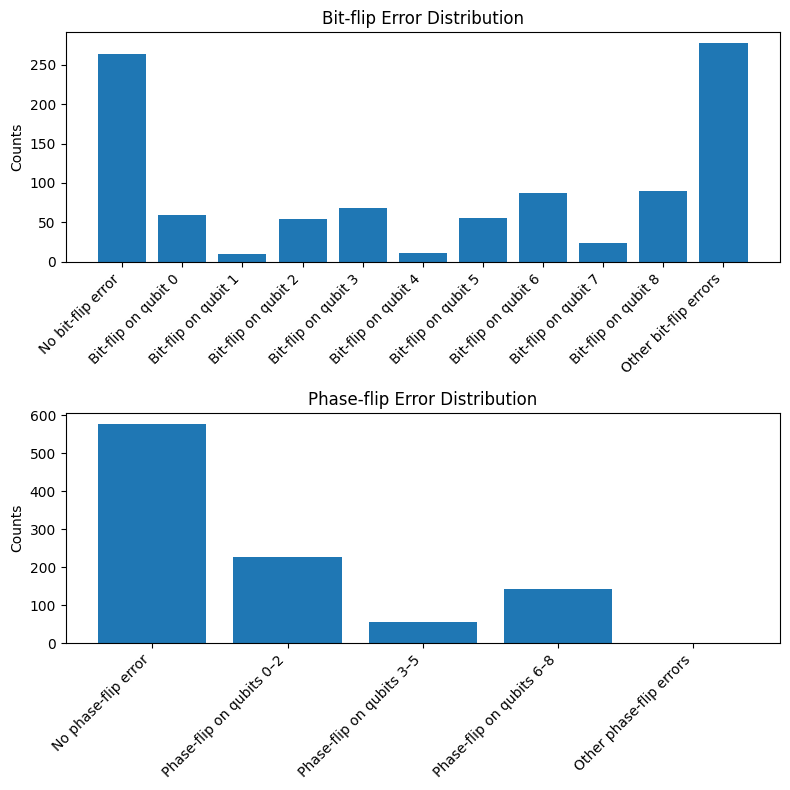

In [ ]:
# Define known single-qubit error syndromes
bit_error_lookup = {
    '000000': 'No bit-flip error',
    '100000': 'Bit-flip on qubit 0',
    '110000': 'Bit-flip on qubit 1', 
    '010000': 'Bit-flip on qubit 2',
    '001000': 'Bit-flip on qubit 3',
    '001100': 'Bit-flip on qubit 4',
    '000100': 'Bit-flip on qubit 5',
    '000010': 'Bit-flip on qubit 6',
    '000011': 'Bit-flip on qubit 7',
    '000001': 'Bit-flip on qubit 8'
}

phase_error_lookup = {
    '00': 'No phase-flip error',
    '10': 'Phase-flip on qubits 0–2',
    '11': 'Phase-flip on qubits 3–5', 
    '01': 'Phase-flip on qubits 6–8'
}

# Add entries for multi-qubit/unknown errors
bit_error_lookup['other'] = 'Other bit-flip errors'
phase_error_lookup['other'] = 'Other phase-flip errors'

# Initialize syndrome counters
bit_error_specifics = {syndrome: 0 for syndrome in bit_error_lookup}
phase_error_specifics = {syndrome: 0 for syndrome in phase_error_lookup}

# Assume counts is defined elsewhere
# counts = {'00000000': 512, '11000010': 100, ...}
total_shots = 1000

# Count occurrences
for syndrome, count in counts.items():
    bit_syndrome = syndrome[:6]
    phase_syndrome = syndrome[-2:]

    if bit_syndrome in bit_error_specifics:
        bit_error_specifics[bit_syndrome] += count
    else:
        bit_error_specifics['other'] += count

    if phase_syndrome in phase_error_specifics:
        phase_error_specifics[phase_syndrome] += count
    else:
        phase_error_specifics['other'] += count

# Print analysis
print("\nBit-flip Error Analysis:")
for syndrome, description in bit_error_lookup.items():
    count = bit_error_specifics.get(syndrome, 0)
    probability = (count / total_shots) * 100
    print(f"{description}: {count} ({probability:.1f}%)")

print("\nPhase-flip Error Analysis:")
for syndrome, description in phase_error_lookup.items():
    count = phase_error_specifics.get(syndrome, 0)
    probability = (count / total_shots) * 100
    print(f"{description}: {count} ({probability:.1f}%)")

# Plot results
plt.figure(figsize=(8, 8))

# Bit-flip bar plot
plt.subplot(2, 1, 1)
plt.bar(bit_error_lookup.values(), [bit_error_specifics[k] for k in bit_error_lookup])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Counts')
plt.title('Bit-flip Error Distribution')

# Phase-flip bar plot
plt.subplot(2, 1, 2)
plt.bar(phase_error_lookup.values(), [phase_error_specifics[k] for k in phase_error_lookup])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Counts')
plt.title('Phase-flip Error Distribution')

plt.tight_layout()
plt.show()

In [182]:
#verify with noiseless simulation
job = QasmSim.run(tqc, shots=100)
result = job.result()
counts = result.get_counts()
print(counts)
# plot_histogram(counts)

{'00000000': 100}


## Run full Shor Code on a real QPU

In [183]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_sherbrooke')>


### Test with a circuit that only encodes the logical qubit (no syndromes) first to verify readout etc.

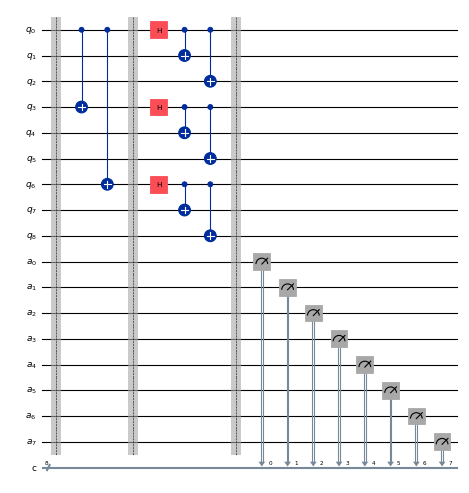

In [184]:
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=False, add_error=False, phase_syn=False, bit_syn=False, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)


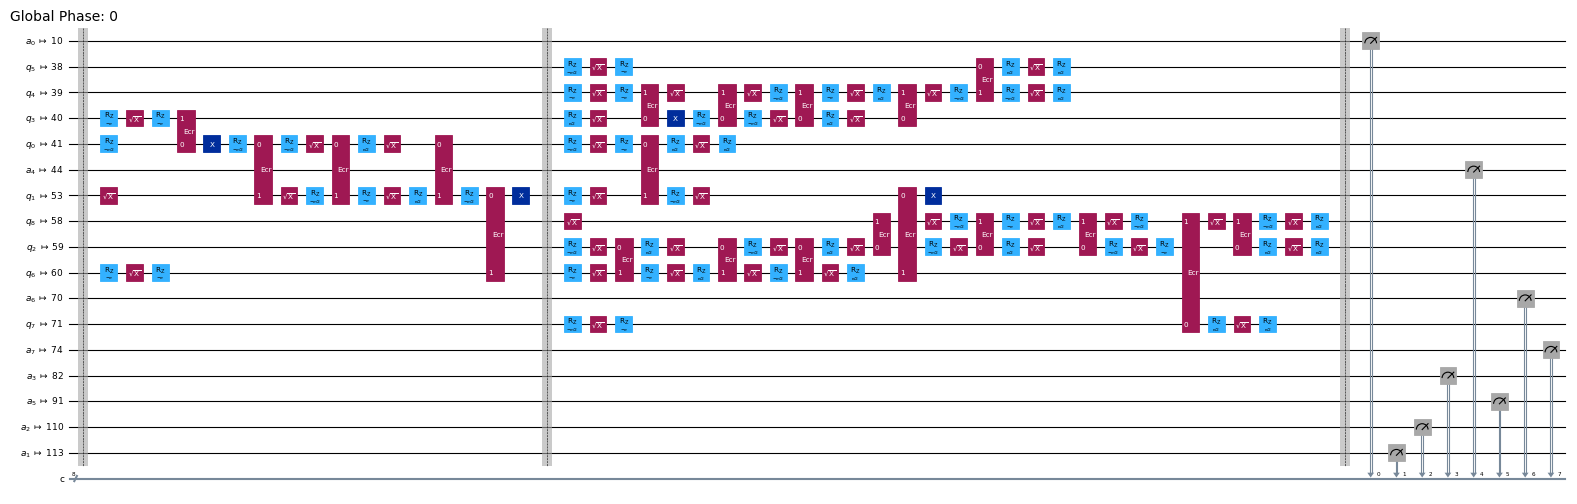

In [185]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

In [554]:
shots = 1000
sampler = Sampler(backend) #define the backend QPU to run on
job = sampler.run([tqc],shots=shots) #run on the QPU
result = job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=8>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-05 16:24:35', stop='2025-04-05 16:24:36', size=1000>)])}, 'version': 2})
{'00000000': 975, '00001000': 4, '00100000': 2, '00010000': 5, '00000001': 7, '00000010': 1, '00000100': 3, '10000000': 3}


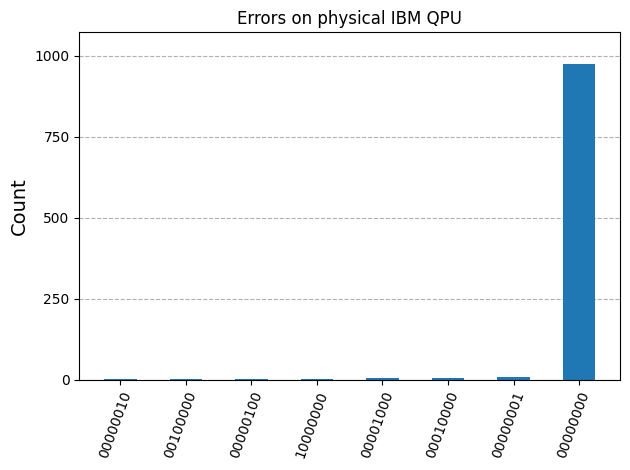

In [555]:

print(result)
counts = result[0].data.c.get_counts() #in a 'string' s? now?

print(counts)

plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

Excellent. We have confirmed the encoding circuit 'works' in that if no syndrome is added, the ancilla qubits just read zeros. 
It was possible that readout error would have prevented even this without verifying.

## Add the bit syndrome measurements

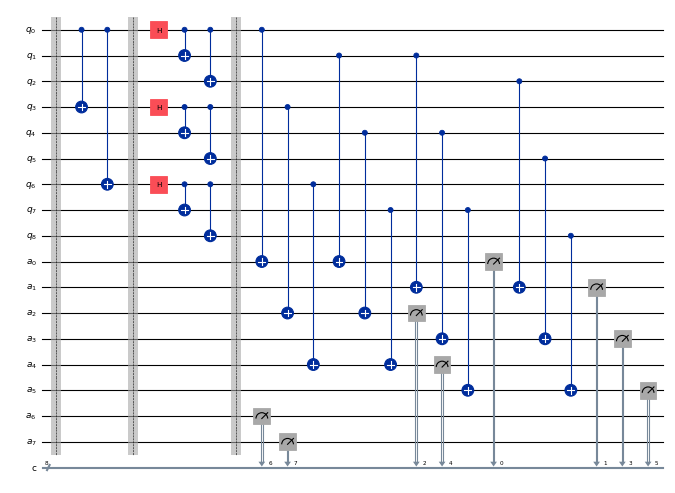

In [527]:
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=False, add_error=False, phase_syn=False, bit_syn=True, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)


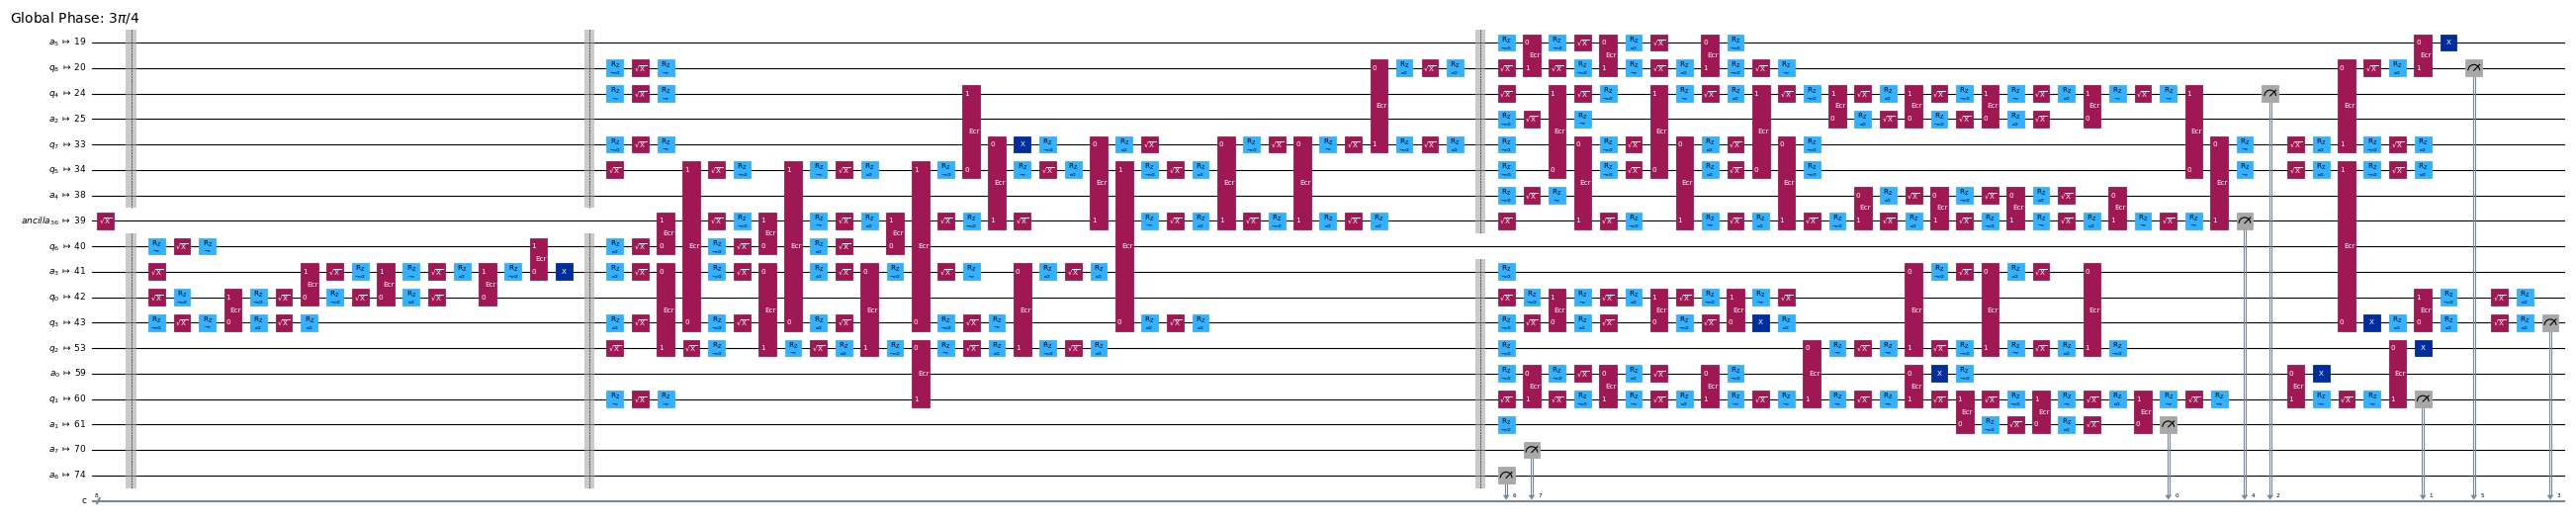

In [537]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

In [538]:
shots = 1000
sampler = Sampler(backend) #define the backend QPU to run on
job = sampler.run([tqc],shots=shots) #run on the QPU
result = job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=8>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-05 16:17:52', stop='2025-04-05 16:17:53', size=1000>)])}, 'version': 2})
{'00100000': 19, '00000000': 568, '00011000': 4, '00001000': 125, '00000100': 38, '00001100': 47, '00000001': 12, '00000010': 34, '00000101': 1, '00000011': 10, '00010000': 59, '00110001': 1, '00000110': 4, '00110000': 24, '00101000': 7, '00111000': 3, '00001101': 1, '00011100': 5, '00110010': 2, '00001110': 5, '00100001': 2, '00010100': 4, '10000000': 4, '00110100': 2, '00010010': 3, '00001011': 2, '00001111': 2, '00001010': 7, '00011011': 1, '00010001': 1, '00100100': 1, '01000100': 1, '00100010': 1}


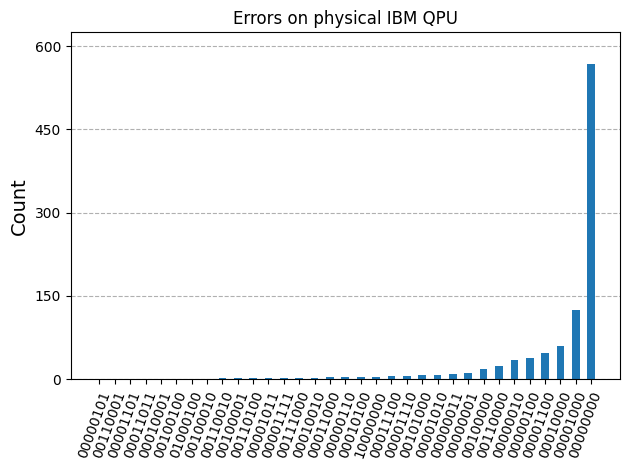

In [539]:
print(result)
counts = result[0].data.c.get_counts() #in a 'string' s? now?
print(counts)
plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')


Error Type Distribution:
No errors: 568 (56.8%)
Bit flip only: 427 (42.7%)
Phase flip only: 4 (0.4%)
Both bit+phase: 1 (0.1%)


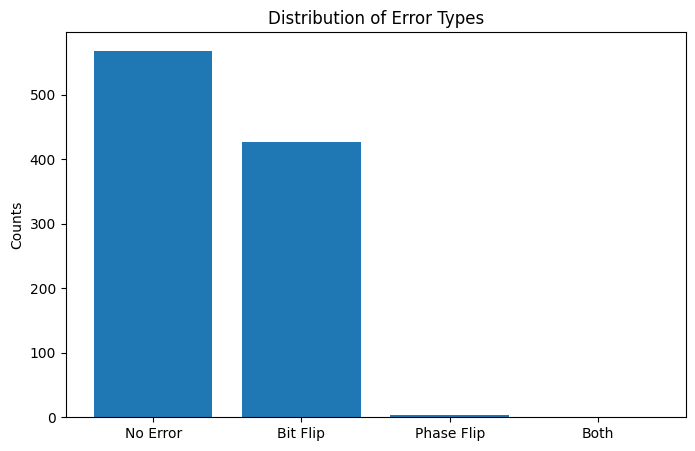

In [541]:
# Analyze error types from measurement results
bit_error_counts = 0
phase_error_counts = 0
both_error_counts = 0
no_error_counts = 0

for syndrome, count in counts.items():
    # Reverse bit string before parsing
    reversed_syndrome = syndrome[::-1]
    
    # Parse syndrome measurements
    bit_syndrome = reversed_syndrome[0:6]
    phase_syndrome = reversed_syndrome[-2:]
    
    # Count different error types
    has_bit_error = '1' in bit_syndrome
    has_phase_error = '1' in phase_syndrome
    
    if has_bit_error and has_phase_error:
        both_error_counts += count
    elif has_bit_error:
        bit_error_counts += count 
    elif has_phase_error:
        phase_error_counts += count
    else:
        no_error_counts += count

total_shots = 1000

print(f"\nError Type Distribution:")
print(f"No errors: {no_error_counts} ({no_error_counts/total_shots*100:.1f}%)")
print(f"Bit flip only: {bit_error_counts} ({bit_error_counts/total_shots*100:.1f}%)")
print(f"Phase flip only: {phase_error_counts} ({phase_error_counts/total_shots*100:.1f}%)")
print(f"Both bit+phase: {both_error_counts} ({both_error_counts/total_shots*100:.1f}%)")

# Create bar plot of error distributions
labels = ['No Error', 'Bit Flip', 'Phase Flip', 'Both']
values = [no_error_counts, bit_error_counts, phase_error_counts, both_error_counts]
plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.title('Distribution of Error Types')
plt.ylabel('Counts')
plt.show()



Bit-flip Error Analysis:
No bit-flip error: 628 (62.8%)
Bit-flip on qubit 0: 4 (0.4%)
Bit-flip on qubit 1: 0 (0.0%)
Bit-flip on qubit 2: 5 (0.5%)
Bit-flip on qubit 3: 66 (6.6%)
Bit-flip on qubit 4: 0 (0.0%)
Bit-flip on qubit 5: 81 (8.1%)
Bit-flip on qubit 6: 220 (22.0%)
Bit-flip on qubit 7: 0 (0.0%)
Bit-flip on qubit 8: 131 (13.1%)

Phase-flip Error Analysis:
No phase-flip error: 908 (90.8%)
Phase-flip on qubits 0–2: 48 (4.8%)
Phase-flip on qubits 3–5: 15 (1.5%)
Phase-flip on qubits 6–8: 29 (2.9%)


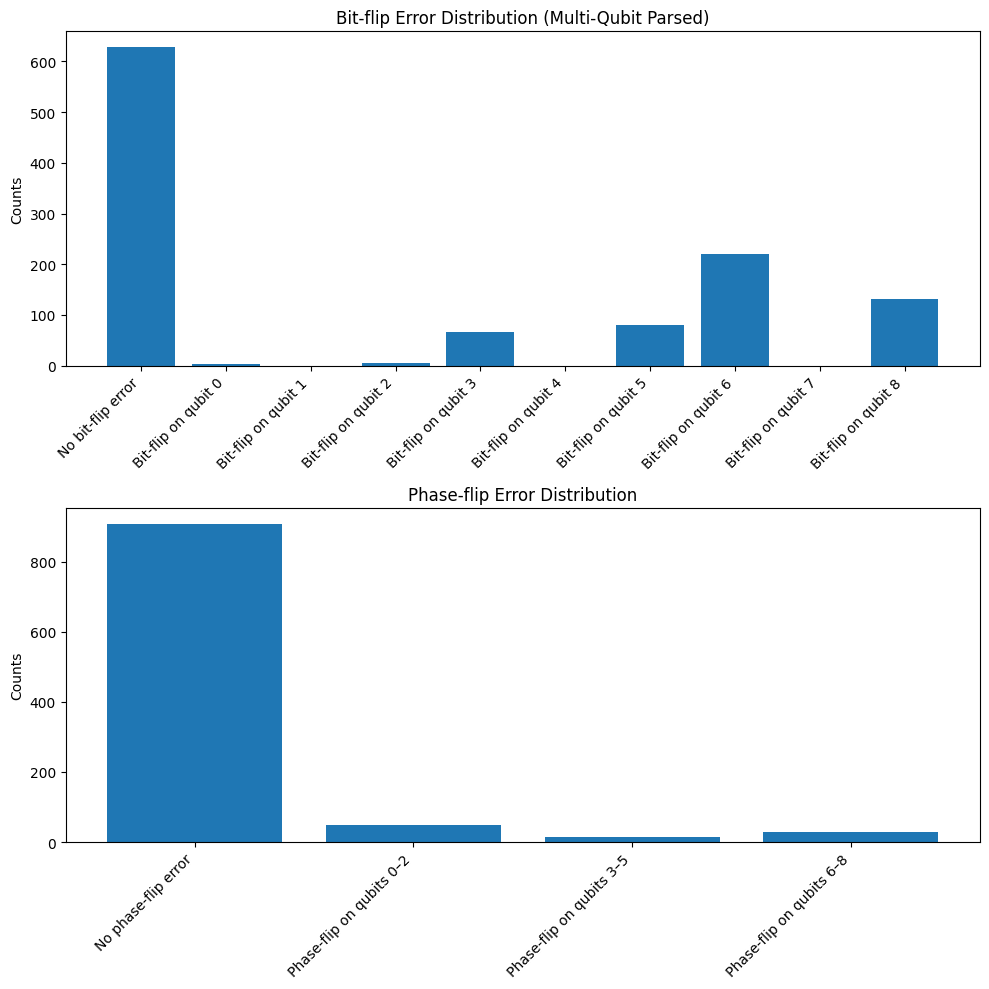

In [532]:
import matplotlib.pyplot as plt

# Define single-qubit bit-flip error bins
bit_error_lookup = {
    '000000': 'No bit-flip error',
    '100000': 'Bit-flip on qubit 0',
    '110000': 'Bit-flip on qubit 1',
    '010000': 'Bit-flip on qubit 2',
    '001000': 'Bit-flip on qubit 3',
    '001100': 'Bit-flip on qubit 4', 
    '000100': 'Bit-flip on qubit 5',
    '000010': 'Bit-flip on qubit 6',
    '000011': 'Bit-flip on qubit 7',
    '000001': 'Bit-flip on qubit 8'
}

# Define phase-flip syndromes
phase_error_lookup = {
    '00': 'No phase-flip error',
    '10': 'Phase-flip on qubits 0–2',
    '11': 'Phase-flip on qubits 3–5',
    '01': 'Phase-flip on qubits 6–8'
}

# Initialize counts
bit_error_specifics = {syndrome: 0 for syndrome in bit_error_lookup}
phase_error_specifics = {syndrome: 0 for syndrome in phase_error_lookup}

# Assume counts = {'00000000': 512, '11000010': 100, ...}
total_shots = 1000

# Process all measurement results
for syndrome, count in counts.items():
    bit_syndrome = syndrome[:6]
    phase_syndrome = syndrome[-2:]

    # Handle bit-flip errors
    if len(bit_syndrome) == 6 and set(bit_syndrome) <= {'0', '1'}:
        if bit_syndrome == '000000':
            bit_error_specifics['000000'] += count
        else:
            # Decompose into per-qubit errors
            for i, bit in enumerate(bit_syndrome):
                if bit == '1':
                    single = list('000000')
                    single[i] = '1'
                    single_key = ''.join(single)
                    if single_key in bit_error_specifics:
                        bit_error_specifics[single_key] += count
    # else: ignore invalid bit_syndrome

    # Handle phase-flip errors
    if phase_syndrome in phase_error_specifics:
        phase_error_specifics[phase_syndrome] += count
    # else: ignore invalid phase_syndrome

# --- Print Analysis ---
print("\nBit-flip Error Analysis:")
for syndrome, description in bit_error_lookup.items():
    count = bit_error_specifics[syndrome]
    probability = (count / total_shots) * 100
    print(f"{description}: {count} ({probability:.1f}%)")

print("\nPhase-flip Error Analysis:")
for syndrome, description in phase_error_lookup.items():
    count = phase_error_specifics[syndrome]
    probability = (count / total_shots) * 100
    print(f"{description}: {count} ({probability:.1f}%)")

# --- Plot Results ---
plt.figure(figsize=(10, 10))

# Bit-flip plot
plt.subplot(2, 1, 1)
plt.bar(bit_error_lookup.values(), [bit_error_specifics[k] for k in bit_error_lookup])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Counts')
plt.title('Bit-flip Error Distribution (Multi-Qubit Parsed)')

# Phase-flip plot
plt.subplot(2, 1, 2)
plt.bar(phase_error_lookup.values(), [phase_error_specifics[k] for k in phase_error_lookup])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Counts')
plt.title('Phase-flip Error Distribution')

plt.tight_layout()
plt.show()


### Excellent! We're seeing that no bit flips are the most likely outcome! That suggests the results are accurate.

## Full Phase syndrome on real QPU

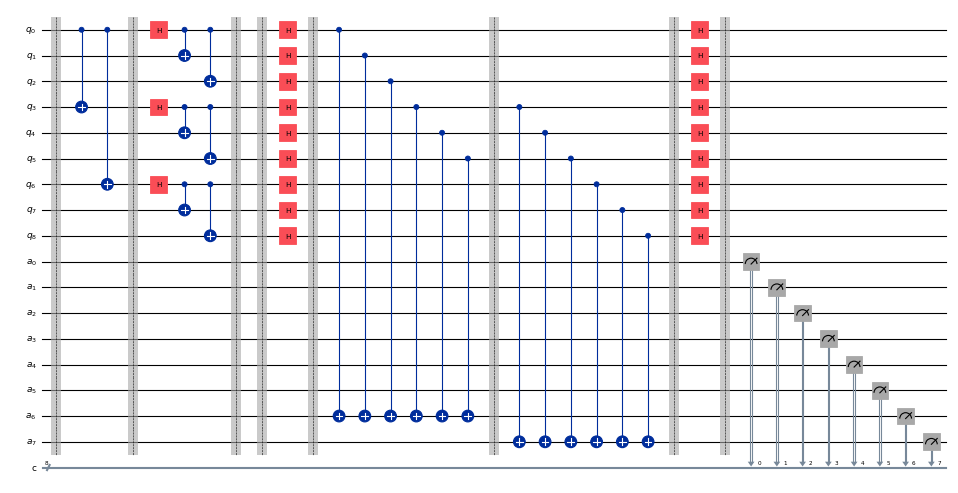

In [248]:
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=True, add_error=False, phase_syn=True, bit_syn=False, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

In [202]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
# tqc.draw('mpl',scale=0.4 ,fold = 100)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)


In [203]:
shots = 1000
sampler = Sampler(backend) #define the backend QPU to run on
job = sampler.run([tqc],shots=shots) #run on the QPU
result = job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=8>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-05 19:08:13', stop='2025-04-05 19:08:14', size=1000>)])}, 'version': 2})
{'00000000': 302, '10000010': 1, '01000000': 270, '11000000': 191, '10000000': 212, '00000100': 3, '00000010': 1, '11000100': 3, '01000010': 3, '00100000': 3, '01000100': 2, '01001000': 1, '01010000': 1, '11000010': 1, '00010000': 1, '10000001': 1, '10000100': 1, '11000001': 1, '00000001': 1, '11010000': 1}


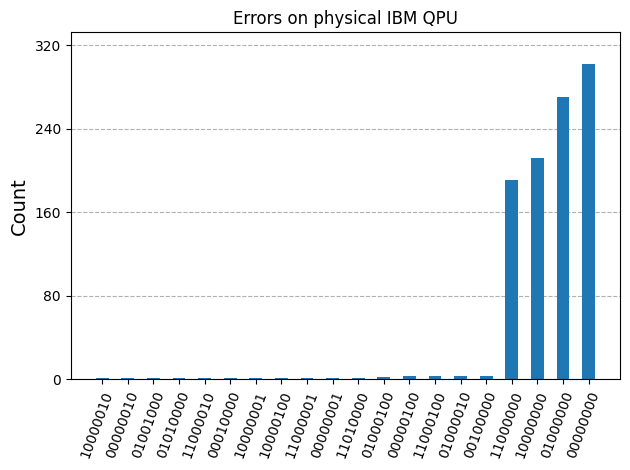

In [204]:
print(result)
counts = result[0].data.c.get_counts() #in a 'string' s? now?
print(counts)
plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

In [249]:
#verify noiseless simulation is all zeros
job = QasmSim.run(tqc, shots=100)
result = job.result()
counts = result.get_counts()
print(counts)

{'00000000': 100}


## Hmm.. that looks like just noise... Maybe we can change the circuit a little to improve the results.

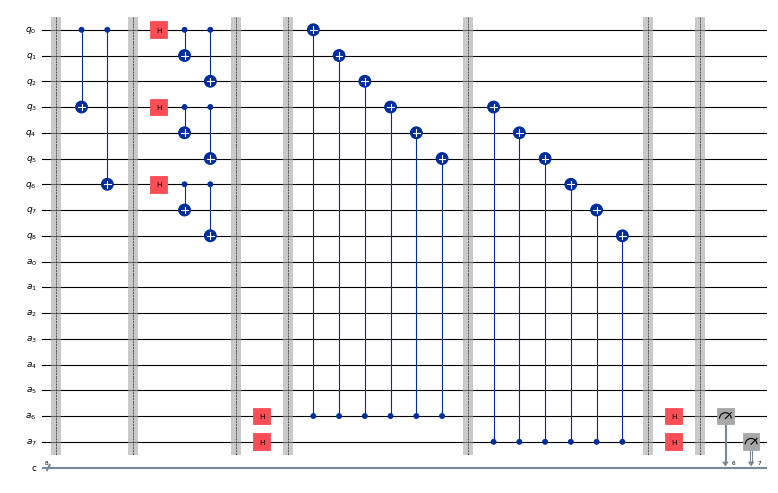

In [283]:
with_barriers = True
# Main registers
qr = QuantumRegister(9, 'q')  # 9 data qubits
anc = QuantumRegister(8, 'a')  # 8 ancilla qubits for syndrome measurements
cr = ClassicalRegister(8, 'c')  # 8 classical bits for syndrome results

qc = QuantumCircuit(qr, anc, cr)

qc = encode_shor_code()

"""Add Phase syndrome measurement to Shor code"""
qc.h(anc[6])
qc.h(anc[7])

if with_barriers:
    qc.barrier()

# Compare first and second block
qc.cx(anc[6], 0)
qc.cx(anc[6], 1)
qc.cx(anc[6], 2)

qc.cx(anc[6], 3)
qc.cx(anc[6], 4)
qc.cx(anc[6], 5)

if with_barriers:
    qc.barrier()

# Compare second and third block
qc.cx(anc[7], 3)  
qc.cx(anc[7], 4)  
qc.cx(anc[7], 5)  

qc.cx(anc[7], 6)
qc.cx(anc[7], 7)
qc.cx(anc[7], 8)

if with_barriers:
    qc.barrier()

qc.h(anc[6])
qc.h(anc[7])

if with_barriers:
    qc.barrier()

'''Measure all ancilla to get syndromes'''
qc.measure(anc[6:8], cr[6:8])

qc.draw('mpl',scale=0.4 ,fold = 100)

In [285]:
#verify noiseless simulation is all zeros
job = QasmSim.run(qc, shots=100)
result = job.result()
counts = result.get_counts()
print(counts)

{'00000000': 100}


In [260]:
backend = FakeBrisbane()

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)


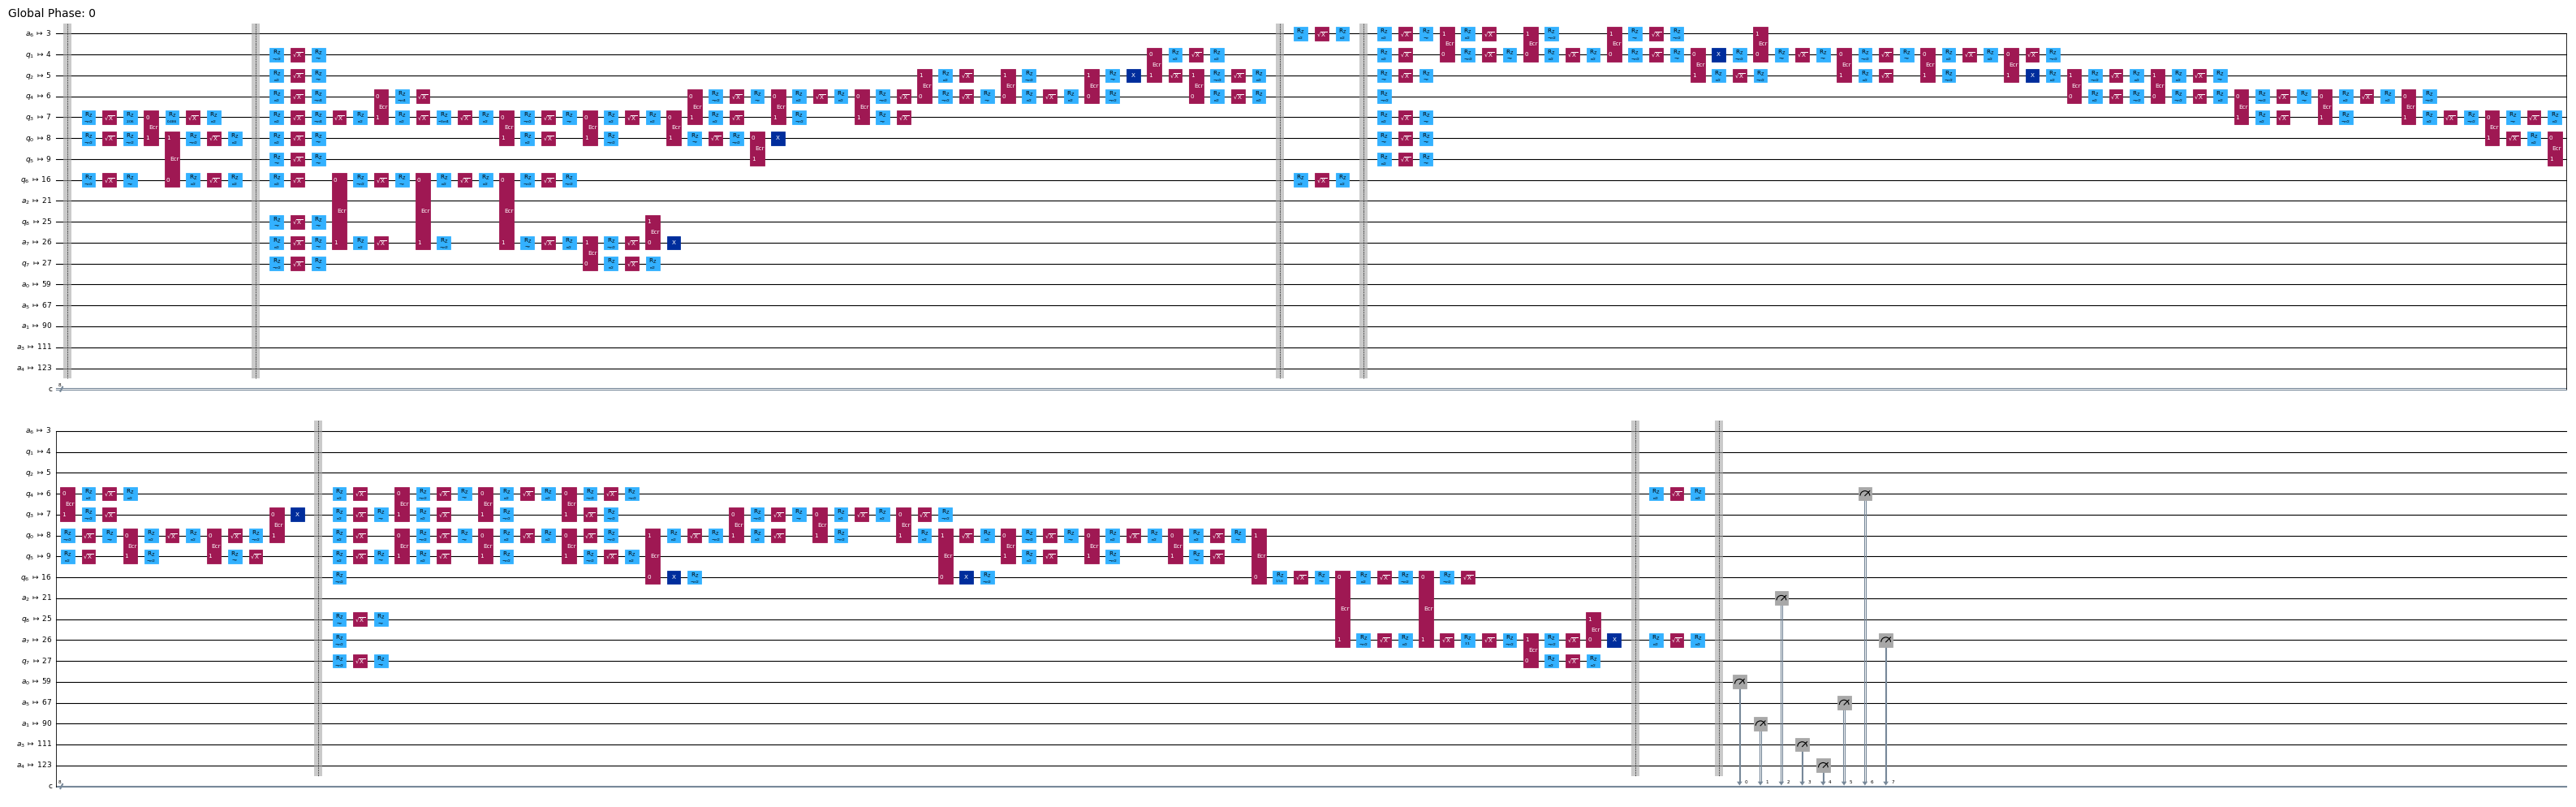

In [263]:
tqc = transpile(qc, backend)
# tqc.draw('mpl',scale=0.4 ,fold = 120)

# pm = generate_preset_pass_manager(optimization_level=1, backend=backend, seed_transpiler=0)
# tqc = pm.run(qc)
# tqc.draw('mpl',scale=0.4 ,fold = 100)

{'01111100': 1, '01000110': 2, '10101001': 1, '00000000': 120, '00010001': 7, '00010000': 21, '11001000': 15, '00110101': 1, '01000100': 7, '00000010': 20, '10000000': 150, '00010010': 5, '10000100': 42, '11001010': 1, '00000110': 7, '01000000': 34, '11000000': 40, '10001000': 29, '01000010': 4, '00000100': 31, '10101000': 1, '00000001': 39, '10110000': 2, '10000010': 26, '10000001': 52, '11010000': 6, '11000001': 12, '10010000': 32, '00100001': 1, '11000110': 7, '00001100': 6, '11000100': 8, '10010010': 8, '01010101': 1, '01000011': 1, '11100000': 2, '11001011': 3, '00000101': 11, '10100001': 1, '00001000': 20, '00100000': 4, '10010001': 14, '10000011': 5, '01000101': 3, '11001101': 1, '10011011': 1, '00000011': 3, '00010011': 3, '00001101': 1, '10001010': 9, '00000111': 1, '01000001': 8, '00100010': 2, '11000101': 7, '10000101': 17, '10101100': 1, '01010000': 5, '10000110': 5, '10100000': 3, '00001001': 9, '10001001': 9, '01010001': 1, '10001100': 4, '00011000': 4, '01010100': 1, '10

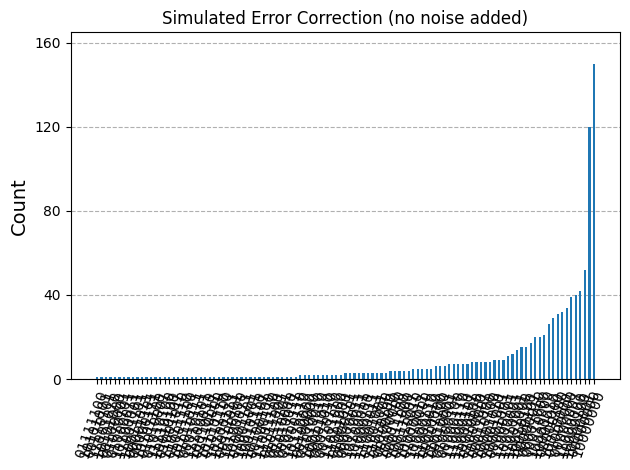

In [266]:
shots = 1000
job = backend.run(tqc, shots=shots)
result = job.result()

counts = result.get_counts()
print(counts)

plot_histogram(counts,title='Simulated Error Correction (no noise added)' , sort = 'value', bar_labels=False)

In [212]:
shots = 1000
sampler = Sampler(backend) #define the backend QPU to run on
job = sampler.run([tqc],shots=shots) #run on the QPU
result = job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=8>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-05 19:13:14', stop='2025-04-05 19:13:15', size=1000>)])}, 'version': 2})
{'01000000': 191, '00000000': 286, '10000000': 307, '11000000': 192, '01000010': 1, '01010000': 3, '00000001': 2, '11000100': 2, '10000001': 1, '01000001': 3, '00010000': 3, '10010000': 3, '00000010': 2, '00000100': 1, '10000010': 1, '00001000': 1, '01100000': 1}


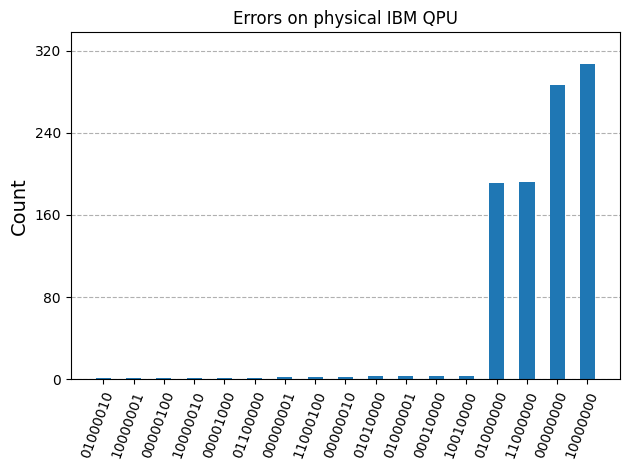

In [213]:
print(result)
counts = result[0].data.c.get_counts() #in a 'string' s? now?
print(counts)
plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

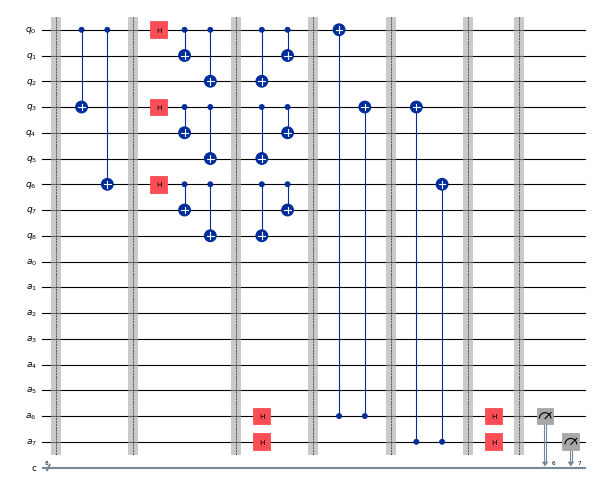

In [241]:

with_barriers = True

# Main registers
qr = QuantumRegister(9, 'q')  # 9 data qubits
anc = QuantumRegister(8, 'a')  # 8 ancilla qubits for syndrome measurements
cr = ClassicalRegister(8, 'c')  # 8 classical bits for syndrome results

qc = QuantumCircuit(qr, anc, cr)

qc = encode_shor_code()

# Unencode the Shor code by applying encoding operations in reverse
qc.cx(0,2)
qc.cx(0,1)

qc.cx(3,5)
qc.cx(3,4)


qc.cx(6,8)
qc.cx(6,7)


"""Add Phase syndrome measurement to Shor code"""
# Phase flip syndromes (between blocks)
# (Convert Z errors to X errors)

# for qubit in range(0,9):
#     qc.h(qubit)
# qc.h(0)
# qc.h(3)
# qc.h(6)

qc.h(anc[6])
qc.h(anc[7])


if with_barriers:
    qc.barrier()


# Compare first and second block
qc.cx(anc[6],0)
# qc.cx(1, anc[6])
# qc.cx(2, anc[6])

qc.cx( anc[6],3)
# qc.cx(4, anc[6])
# qc.cx(5, anc[6])

if with_barriers:
    qc.barrier()

# Compare second and third block
qc.cx( anc[7],3)  
# qc.cx(4, anc[7])  
# qc.cx(5, anc[7])  

qc.cx( anc[7],6)
# qc.cx(7, anc[7])
# qc.cx(8, anc[7])


if with_barriers:
    qc.barrier()

qc.h(anc[6])
qc.h(anc[7])


# for qubit in range(0,9):
#     qc.h(qubit)

if with_barriers:
    qc.barrier()


'''Measure all ancilla to get syndromes'''
qc.measure(anc[-2:], cr[-2:])

qc.draw('mpl',scale=0.4 ,fold = 100)

In [561]:
# qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=True, add_error=False, phase_syn=True, bit_syn=False, encode=True)
# qc.draw('mpl',scale=0.4 ,fold = 100)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\bobni\anaconda3\envs\qc\Lib\site-packages\qiskit\providers\__init__.py)


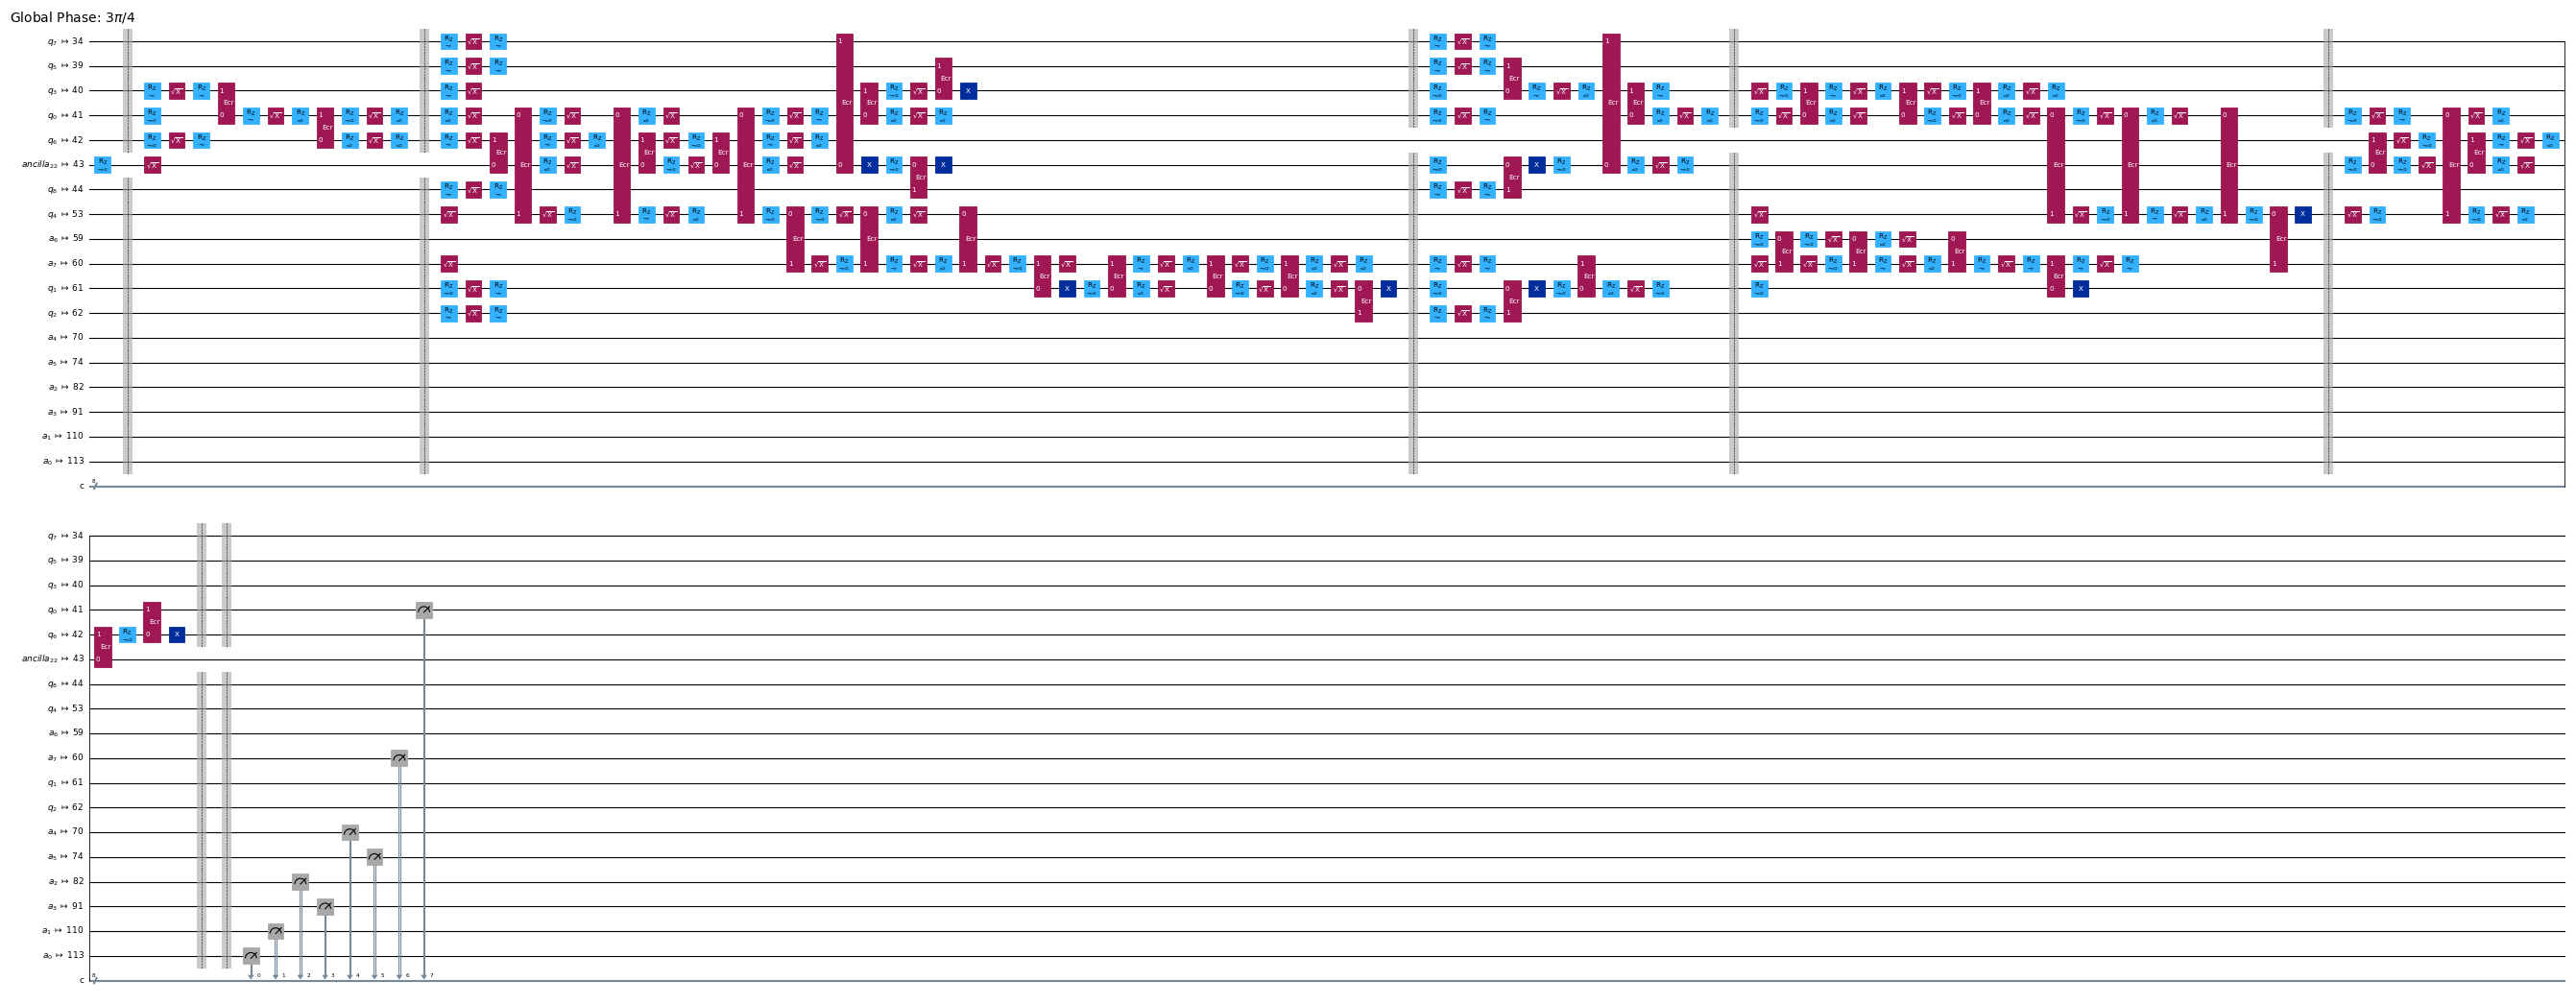

In [235]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

In [236]:
shots = 1000
sampler = Sampler(backend) #define the backend QPU to run on
job = sampler.run([tqc],shots=shots) #run on the QPU
result = job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=8>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-05 19:54:23', stop='2025-04-05 19:54:24', size=1000>)])}, 'version': 2})
{'10000000': 685, '00000000': 166, '11000000': 53, '01000000': 79, '10000010': 5, '10010000': 6, '00010000': 2, '10000001': 1, '00000010': 1, '00001000': 1, '00000001': 1}


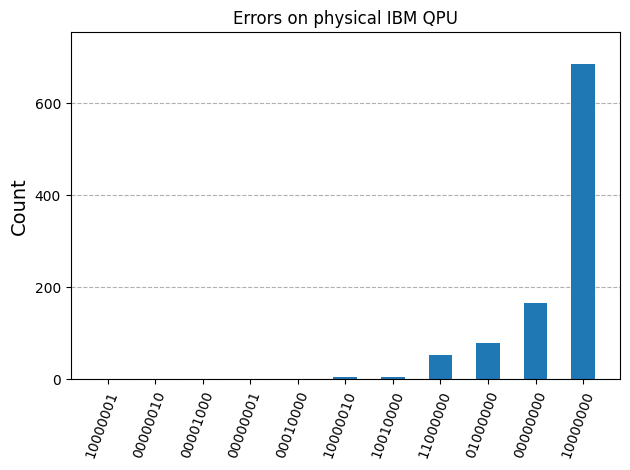

In [237]:
print(result)
counts = result[0].data.c.get_counts() #in a 'string' s? now?
print(counts)
plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')


Phase Error Totals:
00: 502 shots - No phase-flip error
10: 166 shots - Phase-flip on qubits 0,1,2
01: 237 shots - Phase-flip on qubits 6,7,8
11: 95 shots - Phase-flip on qubits 3,4,5


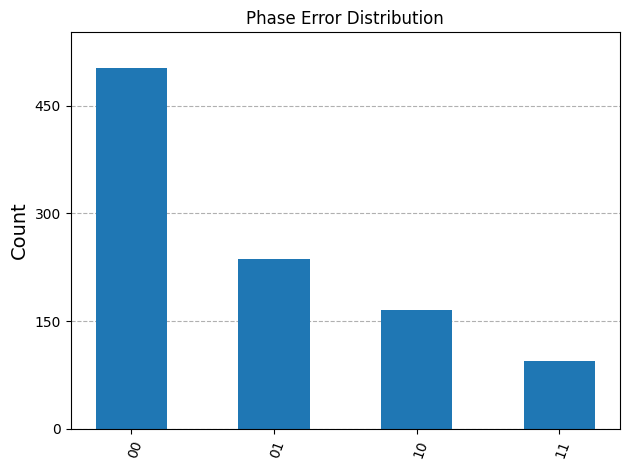

In [619]:
# Create syndrome lookup tables

phase_error_lookup = {
    '00': 'No phase-flip error',
    '10': 'Phase-flip on qubits 0,1,2',
    '11': 'Phase-flip on qubits 3,4,5', 
    '01': 'Phase-flip on qubits 6,7,8'
}

# Get the measured syndrome from counts
# Initialize error counters
phase_error_counts = {}

# Process each syndrome measurement
for syndrome, count in counts.items():
    # For each syndrome measurement, add its count to the appropriate error type
    reversed_syndrome = syndrome[::-1]
    phase_syndrome = reversed_syndrome[-2:]
    
    # Update phase error counts  
    if phase_syndrome not in phase_error_counts:
        phase_error_counts[phase_syndrome] = 0
    phase_error_counts[phase_syndrome] += count

print("\nPhase Error Totals:") 
for syndrome, count in phase_error_counts.items():
    error_desc = phase_error_lookup.get(syndrome, "Unknown phase error pattern")
    print(f"{syndrome}: {count} shots - {error_desc}")

# Plot histogram of phase error counts
plot_histogram(phase_error_counts, 
              title='Phase Error Distribution',
              bar_labels=False)



Bit-flip Error Analysis:
No bit-flip error: 499 (49.9%)
Bit-flip on qubit 0: 332 (33.2%)
Bit-flip on qubit 1: 0 (0.0%)
Bit-flip on qubit 2: 261 (26.1%)
Bit-flip on qubit 3: 3 (0.3%)
Bit-flip on qubit 4: 0 (0.0%)
Bit-flip on qubit 5: 0 (0.0%)
Bit-flip on qubit 6: 1 (0.1%)
Bit-flip on qubit 7: 0 (0.0%)
Bit-flip on qubit 8: 5 (0.5%)

Phase-flip Error Analysis:
No phase-flip error: 986 (98.6%)
Phase-flip on qubits 0–2: 11 (1.1%)
Phase-flip on qubits 3–5: 0 (0.0%)
Phase-flip on qubits 6–8: 3 (0.3%)


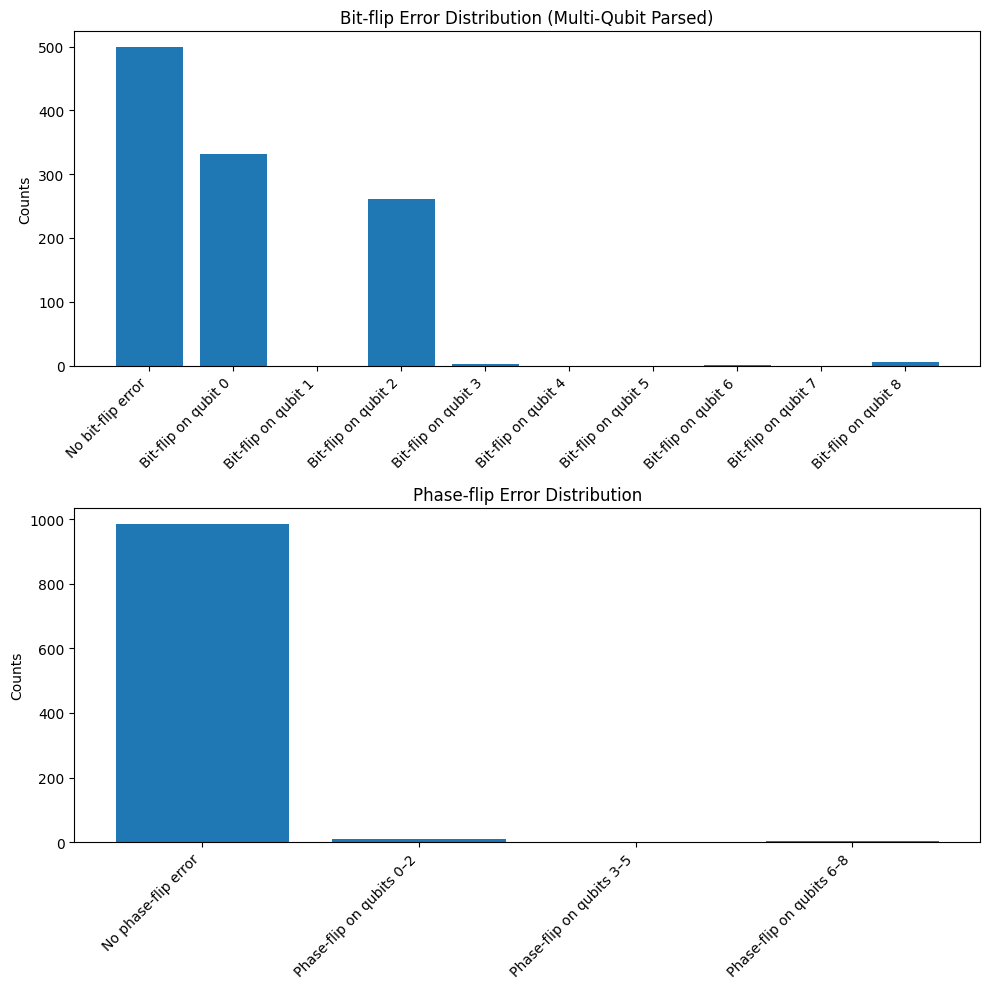

In [620]:

# Define single-qubit bit-flip error bins
bit_error_lookup = {
    '000000': 'No bit-flip error',
    '100000': 'Bit-flip on qubit 0',
    '110000': 'Bit-flip on qubit 1',
    '010000': 'Bit-flip on qubit 2',
    '001000': 'Bit-flip on qubit 3',
    '001100': 'Bit-flip on qubit 4', 
    '000100': 'Bit-flip on qubit 5',
    '000010': 'Bit-flip on qubit 6',
    '000011': 'Bit-flip on qubit 7',
    '000001': 'Bit-flip on qubit 8'
}

# Define phase-flip syndromes
phase_error_lookup = {
    '00': 'No phase-flip error',
    '10': 'Phase-flip on qubits 0–2',
    '11': 'Phase-flip on qubits 3–5',
    '01': 'Phase-flip on qubits 6–8'
}

# Initialize counts
bit_error_specifics = {syndrome: 0 for syndrome in bit_error_lookup}
phase_error_specifics = {syndrome: 0 for syndrome in phase_error_lookup}

# Assume counts = {'00000000': 512, '11000010': 100, ...}
total_shots = 1000

# Process all measurement results
for syndrome, count in counts.items():
    bit_syndrome = syndrome[:6]
    phase_syndrome = syndrome[-2:]

    # Handle bit-flip errors
    if len(bit_syndrome) == 6 and set(bit_syndrome) <= {'0', '1'}:
        if bit_syndrome == '000000':
            bit_error_specifics['000000'] += count
        else:
            # Decompose into per-qubit errors
            for i, bit in enumerate(bit_syndrome):
                if bit == '1':
                    single = list('000000')
                    single[i] = '1'
                    single_key = ''.join(single)
                    if single_key in bit_error_specifics:
                        bit_error_specifics[single_key] += count
    # else: ignore invalid bit_syndrome

    # Handle phase-flip errors
    if phase_syndrome in phase_error_specifics:
        phase_error_specifics[phase_syndrome] += count
    # else: ignore invalid phase_syndrome

# --- Print Analysis ---
print("\nBit-flip Error Analysis:")
for syndrome, description in bit_error_lookup.items():
    count = bit_error_specifics[syndrome]
    probability = (count / total_shots) * 100
    print(f"{description}: {count} ({probability:.1f}%)")

print("\nPhase-flip Error Analysis:")
for syndrome, description in phase_error_lookup.items():
    count = phase_error_specifics[syndrome]
    probability = (count / total_shots) * 100
    print(f"{description}: {count} ({probability:.1f}%)")

# --- Plot Results ---
plt.figure(figsize=(10, 10))

# Bit-flip plot
plt.subplot(2, 1, 1)
plt.bar(bit_error_lookup.values(), [bit_error_specifics[k] for k in bit_error_lookup])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Counts')
plt.title('Bit-flip Error Distribution (Multi-Qubit Parsed)')

# Phase-flip plot
plt.subplot(2, 1, 2)
plt.bar(phase_error_lookup.values(), [phase_error_specifics[k] for k in phase_error_lookup])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Counts')
plt.title('Phase-flip Error Distribution')

plt.tight_layout()
plt.show()


Hmmm... seems like all noise...

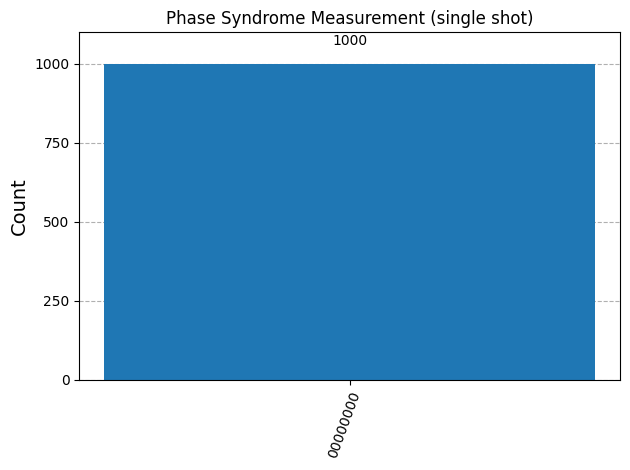

In [574]:
job = QasmSim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts, title='Phase Syndrome Measurement (single shot)' , sort='asc')

## Analysis Questions

1. How does the error correction threshold change with the number of qubits?
2. What are the trade-offs between different error correction codes?
3. Why can't we just measure the qubits directly to detect errors?
4. How would you implement error correction in a real quantum computer?

## Additional Challenges

1. Implement the Steane 7-qubit code
2. Compare the performance of different codes under various error models
3. Design a circuit to measure the fidelity of the error correction

## References

1. [Quantum Error Correction for Beginners](https://arxiv.org/abs/0905.2794)
2. [Surface Codes: Towards Practical Large-Scale Quantum Computation](https://arxiv.org/abs/1208.0928)
3. Nielsen & Chuang, Chapter 10: Quantum Error Correction